In [6]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from src.nce.binary import NceBinaryCrit
from src.nce.cnce import CondNceCrit

from src.noise_distr.normal import MultivariateNormal
from src.noise_distr.conditional_normal import ConditionalMultivariateNormal

from src.models.ring_model.ring_model import RingModel, RingModelNCE, unnorm_ring_model_log_pdf
from src.data.ring_model_dataset import RingModelDataset

from src.training.model_training import train_model
from src.training.training_utils import PrecisionErrorMetric, no_change_stopping_condition

## EXPERIMENT HELP FUNCTIONS

In [7]:
# Noise distribution parameters, NCE

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNCEnoise.m
def get_nce_noise_distr_par(y):
    mu = torch.mean(y, dim=0)
    cov = torch.cov(torch.transpose(y, 0, 1))
    
    return mu, cov

In [8]:
# Noise distribution parameters, CNCE
# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gNoise.m

def get_cnce_epsilon_base(y):
    return torch.std(y, dim=-1).mean()

def get_cnce_covariance_matrix(epsilon_factor, epsilon_base, num_dims):
    return torch.eye(num_dims) * (epsilon_factor * epsilon_base)**2


# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/estimation/noise/continous/gEpsilonBaseFun.m
def get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision):
    epsilon_factor = get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision)
    epsilon_base = get_cnce_epsilon_base(y)
    return get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))


def evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m):
    
    epsilon_base = get_cnce_epsilon_base(y)
    cov_noise = get_cnce_covariance_matrix(epsilon_factor, epsilon_base, y.size(-1))
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    criterion = CondNceCrit(p_m, p_n)
    y_samples = criterion.sample_noise(neg_sample_size * y.size(0), y)
    
    return criterion.crit(y, y_samples)


def get_cnce_epsilon_factor(y, neg_sample_size, mu, log_precision, thrs_lower=0.05, thrs_upper=0.5, inc_rate=0.2, 
                            dec_rate=0.5, max_iter=500, eps_hard_cap=1000):
    
    loss_zero = np.log(2) # Loss as epsilon -> 0 
    loss_inf = 0  # Loss as epsilon -> inf
    thrs_upper = thrs_upper * loss_zero  
    
    num_dims = y.size(-1)
    p_m = RingModel(mu=mu, log_precision=log_precision)  
    
    epsilon_factor = 0.5  # Start value 

    # Calculate initial loss
    loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

    # Iterate until conditions are met 
    k = 1;
    while (k < max_iter) and (abs(1 - (loss/loss_zero)) < thrs_lower or loss < thrs_upper ) and (epsilon_factor < eps_hard_cap):

        if abs(1 - (loss/loss_zero)) < thrs_lower: 
            epsilon_factor = (1 + inc_rate) * epsilon_factor
        elif loss < thrs_upper:
            epsilon_factor = (1 - dec_rate) * epsilon_factor
   
        loss = evaluate_cnce_loss(epsilon_factor, neg_sample_size, p_m)

        k = k + 1
    
    return epsilon_factor


In [9]:
# Generation of true parameters, parameter initialisation

# Adapted from https://github.com/ciwanceylan/CNCE-matlab/blob/master/matlab/synthetic_data/bin/data_generation/generate_parameters.m
def generate_true_params(mu_min=5, mu_max=10, sigma_min=0.3, sigma_max=1.5):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    z = -0.5 * torch.log(2 * torch.tensor(np.pi)) - torch.log(sigma) 
    
    return mu, precision, z

def initialise_params(mu_min=6, mu_max=8, sigma_min=0.3, sigma_max=1.5, z_min = 0.01):
    mu = (mu_max - mu_min) * torch.rand(1) + mu_min
    sigma = (sigma_max - sigma_min) * torch.rand(1) + sigma_min
    precision = sigma**(-2)
    
    z = torch.rand(1) + z_min

    return mu, torch.log(precision), torch.log(z)


## NOISE DISTRIBUTIONS PLOT

In [10]:
# Some helper functions
def get_grid_data(y_min=-10, y_max=10, grid_size=100):
    ny = np.linspace(y_min, y_max, grid_size)
    Y1, Y2 = np.meshgrid(ny, ny)
    y_grid = torch.tensor(np.column_stack((Y1.reshape(-1), Y2.reshape(-1))))
    
    return y_grid


def sample_nce(y, num_samples):
    mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(y)

    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
    return p_n.sample(torch.Size((num_samples,)))


def sample_cnce(y, num_samples, mu, log_precision, neg_sample_size=10):
    cov_noise = get_cnce_noise_distr_par(y, neg_sample_size, mu, log_precision)
    
    p_n = ConditionalMultivariateNormal(cov=cov_noise)
    
    return p_n.sample(torch.Size((num_samples,)), y)


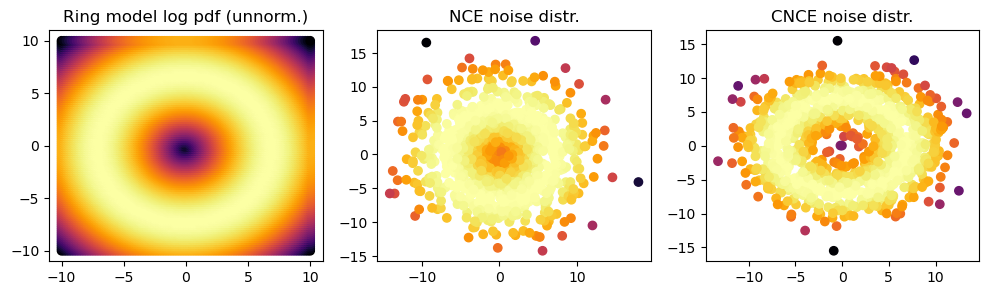

In [14]:
# 2D example
num_dims = 2
mu, precision = 7, 1


# Ring model pdf 
y_grid = get_grid_data()
log_pdf = unnorm_ring_model_log_pdf(y_grid, mu=mu, precision=precision)

# Sample from noise distr. based on some real training data
num_samples = 1000
y = RingModelDataset(sample_size=num_samples, num_dims=num_dims, mu=mu, precision=precision, 
                     root_dir="res/datasets/example_data").get_full_data()

# NCE 
y_samples_nce = sample_nce(y, num_samples)
log_pdf_nce = unnorm_ring_model_log_pdf(y_samples_nce, mu=mu, precision=precision)

# CNCE 
y_samples_cnce = sample_cnce(y, num_samples, mu, torch.log(torch.tensor(precision)))
log_pdf_cnce = unnorm_ring_model_log_pdf(y_samples_cnce, mu=mu, precision=precision)


# Visualise
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

ax[0].scatter(y_grid[:, 0], y_grid[:, 1], c=log_pdf, cmap='inferno')
ax[0].set_title("Ring model log pdf (unnorm.)")

ax[1].scatter(y_samples_nce[:, 0], y_samples_nce[:, 1], c=log_pdf_nce, cmap='inferno')
ax[1].set_title("NCE noise distr.")

ax[2].scatter(y_samples_cnce[:, 0], y_samples_cnce[:, 1], c=log_pdf_cnce, cmap='inferno')
ax[2].set_title("CNCE noise distr.")
            

plt.show()


## EXPERIMENTS

In [15]:
# Data specs
num_dims = 5

# Experiments specs
num_samples = [20, 50, 100, 200]
num_neg_samples = [2, 5, 10]
reps = 10

# Criteria 
criteria = [NceBinaryCrit, CondNceCrit]
crit_labels = ["binary", "conditional"]

# Training specs
batch_size = 32
num_epochs = 100

In [ ]:
# Run experiments

error_res = np.zeros((len(num_samples), len(num_neg_samples), len(criteria), reps))

# Sorry för alla loopar
for i, N in enumerate(num_samples):
    
    for j, J in enumerate(num_neg_samples):
        
        for rep in range(reps):
            
            # Get data 
            mu, precision, _ = generate_true_params()
            error_metric = PrecisionErrorMetric(true_precision=precision).metric            
                        
            training_data = RingModelDataset(sample_size=N, num_dims=num_dims, mu=mu.numpy(), precision=precision.numpy(), 
                                             root_dir="res/datasets/ring_data_size_" + str(N) + "_nn_" + str(J) + "_rep_" + str(rep))
            train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
    
            # Initialise           
            _, log_precision_init, log_z_init = initialise_params()
    
            # Get noise distr. params
            mu_noise_nce, cov_noise_nce = get_nce_noise_distr_par(training_data.get_full_data())
            cov_noise_cnce = get_cnce_noise_distr_par(training_data.get_full_data(), J, mu, log_precision_init)
                        
            for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
            
                if crit == NceBinaryCrit: # TODO: Nicer way to do this comparison?
                    p_m = RingModelNCE(mu=mu, log_precision=log_precision_init, log_part_fn=log_z_init)
                else:
                    p_m = RingModel(mu=mu, log_precision=log_precision_init)
                    
                if crit == CondNceCrit:
                    p_n = ConditionalMultivariateNormal(cov=cov_noise_cnce)
                else:
                    p_n = MultivariateNormal(mu=mu_noise_nce, cov=cov_noise_nce)
                    
                criterion = crit(p_m, p_n)
                
                save_dir = "res/param_error_" + lab + "_samples_" + str(N) + "_num_neg_" + str(J) + "_rep_" + str(rep)
                error_res[i, j, k, rep] = train_model(criterion, error_metric, train_loader, save_dir, neg_sample_size=J, num_epochs=num_epochs,
                                                      stopping_condition=no_change_stopping_condition)

np.save("res/final_param_error_ring_model_all", error_res)

C:\Users\amaol67\PycharmProjects\deep_ext_obj\nbs\..\src\models\ring_model\ring_model.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.log_part_fn = torch.nn.Parameter(torch.tensor(log_part_fn), requires_grad=True)


[1] loss: 9.001
[1] evaluation metric: 9.881
[2] loss: 7.487
[2] evaluation metric: 37.115
[3] loss: 7.254
[3] evaluation metric: 76.425
[4] loss: 6.286
[4] evaluation metric: 128.273
[5] loss: 4.485
[5] evaluation metric: 194.631
[6] loss: 5.315
[6] evaluation metric: 247.916
[7] loss: 4.473
[7] evaluation metric: 261.419
[8] loss: 5.659
[8] evaluation metric: 236.359
[9] loss: 4.387
[9] evaluation metric: 281.661
[10] loss: 5.338
[10] evaluation metric: 237.344
[11] loss: 5.708
[11] evaluation metric: 268.886
[12] loss: 5.084
[12] evaluation metric: 215.538
[13] loss: 6.390
[13] evaluation metric: 312.404
[14] loss: 3.790
[14] evaluation metric: 221.212
[15] loss: 5.042
[15] evaluation metric: 284.010
[16] loss: 6.723
[16] evaluation metric: 258.159
[17] loss: 6.097
[17] evaluation metric: 263.521
[18] loss: 5.327
[18] evaluation metric: 389.644
[19] loss: 5.113
[19] evaluation metric: 419.586
[20] loss: 4.387
[20] evaluation metric: 322.856
[21] loss: 6.207
[21] evaluation metric: 3

[73] loss: 0.388
[73] evaluation metric: 0.701
[74] loss: 0.401
[74] evaluation metric: 0.799
[75] loss: 0.418
[75] evaluation metric: 0.817
[76] loss: 0.378
[76] evaluation metric: 0.837
[77] loss: 0.591
[77] evaluation metric: 0.951
[78] loss: 0.388
[78] evaluation metric: 0.943
[79] loss: 0.292
[79] evaluation metric: 0.906
[80] loss: 0.450
[80] evaluation metric: 0.941
[81] loss: 0.392
[81] evaluation metric: 0.987
[82] loss: 0.558
[82] evaluation metric: 1.122
[83] loss: 0.397
[83] evaluation metric: 1.114
[84] loss: 0.340
[84] evaluation metric: 1.116
[85] loss: 0.465
[85] evaluation metric: 1.223
[86] loss: 0.489
[86] evaluation metric: 1.290
[87] loss: 0.465
[87] evaluation metric: 1.344
[88] loss: 0.505
[88] evaluation metric: 1.457
[89] loss: 0.290
[89] evaluation metric: 1.388
[90] loss: 0.400
[90] evaluation metric: 1.409
[91] loss: 0.338
[91] evaluation metric: 1.440
[92] loss: 0.418
[92] evaluation metric: 1.509
[93] loss: 0.419
[93] evaluation metric: 1.542
[94] loss: 0.

[71] loss: 0.586
[71] evaluation metric: 0.001
[72] loss: 0.561
[72] evaluation metric: 0.001
[73] loss: 0.543
[73] evaluation metric: 0.001
[74] loss: 0.605
[74] evaluation metric: 0.001
[75] loss: 0.561
[75] evaluation metric: 0.001
[76] loss: 0.699
[76] evaluation metric: 0.000
[77] loss: 0.636
[77] evaluation metric: 0.000
[78] loss: 0.578
[78] evaluation metric: 0.000
[79] loss: 0.630
[79] evaluation metric: 0.000
[80] loss: 0.595
[80] evaluation metric: 0.000
[81] loss: 0.528
[81] evaluation metric: 0.000
[82] loss: 0.709
[82] evaluation metric: 0.000
[83] loss: 0.682
[83] evaluation metric: 0.000
[84] loss: 0.609
[84] evaluation metric: 0.000
[85] loss: 0.607
[85] evaluation metric: 0.000
[86] loss: 0.614
[86] evaluation metric: 0.000
[87] loss: 0.635
[87] evaluation metric: 0.000
[88] loss: 0.601
[88] evaluation metric: 0.000
[89] loss: 0.618
[89] evaluation metric: 0.000
[90] loss: 0.637
[90] evaluation metric: 0.000
[91] loss: 0.582
[91] evaluation metric: 0.000
[92] loss: 0.

[48] loss: 0.616
[48] evaluation metric: 0.163
[49] loss: 0.510
[49] evaluation metric: 0.163
[50] loss: 0.569
[50] evaluation metric: 0.154
[51] loss: 0.409
[51] evaluation metric: 0.151
[52] loss: 0.614
[52] evaluation metric: 0.139
[53] loss: 0.422
[53] evaluation metric: 0.139
[54] loss: 0.594
[54] evaluation metric: 0.129
[55] loss: 0.546
[55] evaluation metric: 0.126
[56] loss: 0.562
[56] evaluation metric: 0.120
[57] loss: 0.496
[57] evaluation metric: 0.115
[58] loss: 0.548
[58] evaluation metric: 0.103
[59] loss: 0.503
[59] evaluation metric: 0.098
[60] loss: 0.625
[60] evaluation metric: 0.089
[61] loss: 0.562
[61] evaluation metric: 0.084
[62] loss: 0.610
[62] evaluation metric: 0.073
[63] loss: 0.497
[63] evaluation metric: 0.070
[64] loss: 0.491
[64] evaluation metric: 0.071
[65] loss: 0.696
[65] evaluation metric: 0.060
[66] loss: 0.559
[66] evaluation metric: 0.056
[67] loss: 0.575
[67] evaluation metric: 0.053
[68] loss: 0.533
[68] evaluation metric: 0.054
[69] loss: 0.

[27] loss: 0.718
[27] evaluation metric: 1.596
[28] loss: 0.591
[28] evaluation metric: 1.538
[29] loss: 0.525
[29] evaluation metric: 1.490
[30] loss: 0.610
[30] evaluation metric: 1.416
[31] loss: 0.712
[31] evaluation metric: 1.329
[32] loss: 0.589
[32] evaluation metric: 1.254
[33] loss: 0.626
[33] evaluation metric: 1.203
[34] loss: 0.626
[34] evaluation metric: 1.150
[35] loss: 0.508
[35] evaluation metric: 1.159
[36] loss: 0.602
[36] evaluation metric: 1.110
[37] loss: 0.688
[37] evaluation metric: 1.054
[38] loss: 0.566
[38] evaluation metric: 1.023
[39] loss: 0.576
[39] evaluation metric: 0.983
[40] loss: 0.548
[40] evaluation metric: 0.943
[41] loss: 0.636
[41] evaluation metric: 0.913
[42] loss: 0.617
[42] evaluation metric: 0.876
[43] loss: 0.703
[43] evaluation metric: 0.822
[44] loss: 0.512
[44] evaluation metric: 0.839
[45] loss: 0.584
[45] evaluation metric: 0.809
[46] loss: 0.380
[46] evaluation metric: 0.814
[47] loss: 0.477
[47] evaluation metric: 0.809
[48] loss: 0.

[8] loss: 0.894
[8] evaluation metric: 1.625
[9] loss: 0.810
[9] evaluation metric: 1.451
[10] loss: 0.693
[10] evaluation metric: 1.308
[11] loss: 0.716
[11] evaluation metric: 1.174
[12] loss: 0.655
[12] evaluation metric: 1.073
[13] loss: 0.670
[13] evaluation metric: 1.001
[14] loss: 0.587
[14] evaluation metric: 0.953
[15] loss: 0.681
[15] evaluation metric: 0.899
[16] loss: 0.766
[16] evaluation metric: 0.818
[17] loss: 0.645
[17] evaluation metric: 0.754
[18] loss: 0.682
[18] evaluation metric: 0.697
[19] loss: 0.754
[19] evaluation metric: 0.629
[20] loss: 0.661
[20] evaluation metric: 0.579
[21] loss: 0.809
[21] evaluation metric: 0.515
[22] loss: 0.824
[22] evaluation metric: 0.458
[23] loss: 0.603
[23] evaluation metric: 0.429
[24] loss: 0.597
[24] evaluation metric: 0.410
[25] loss: 0.734
[25] evaluation metric: 0.372
[26] loss: 0.643
[26] evaluation metric: 0.346
[27] loss: 0.673
[27] evaluation metric: 0.322
[28] loss: 0.703
[28] evaluation metric: 0.294
[29] loss: 0.577


[13] loss: 0.739
[13] evaluation metric: 6.182
[14] loss: 0.480
[14] evaluation metric: 5.863
[15] loss: 0.670
[15] evaluation metric: 5.320
[16] loss: 0.547
[16] evaluation metric: 4.918
[17] loss: 0.434
[17] evaluation metric: 4.696
[18] loss: 0.652
[18] evaluation metric: 4.183
[19] loss: 0.620
[19] evaluation metric: 3.864
[20] loss: 0.442
[20] evaluation metric: 3.712
[21] loss: 0.398
[21] evaluation metric: 3.534
[22] loss: 0.646
[22] evaluation metric: 3.200
[23] loss: 0.606
[23] evaluation metric: 2.935
[24] loss: 0.679
[24] evaluation metric: 2.663
[25] loss: 0.579
[25] evaluation metric: 2.403
[26] loss: 0.566
[26] evaluation metric: 2.160
[27] loss: 0.429
[27] evaluation metric: 2.080
[28] loss: 0.553
[28] evaluation metric: 1.879
[29] loss: 0.437
[29] evaluation metric: 1.851
[30] loss: 0.501
[30] evaluation metric: 1.759
[31] loss: 0.425
[31] evaluation metric: 1.700
[32] loss: 0.584
[32] evaluation metric: 1.616
[33] loss: 0.647
[33] evaluation metric: 1.512
[34] loss: 0.

[10] loss: 0.537
[10] evaluation metric: 64.810
[11] loss: 0.223
[11] evaluation metric: 63.381
[12] loss: 0.244
[12] evaluation metric: 60.599
[13] loss: 0.435
[13] evaluation metric: 55.769
[14] loss: 0.646
[14] evaluation metric: 48.361
[15] loss: 0.654
[15] evaluation metric: 41.812
[16] loss: 0.328
[16] evaluation metric: 39.772
[17] loss: 0.598
[17] evaluation metric: 35.560
[18] loss: 0.461
[18] evaluation metric: 32.245
[19] loss: 0.249
[19] evaluation metric: 31.225
[20] loss: 0.738
[20] evaluation metric: 27.119
[21] loss: 0.572
[21] evaluation metric: 24.117
[22] loss: 0.590
[22] evaluation metric: 21.878
[23] loss: 0.215
[23] evaluation metric: 21.509
[24] loss: 0.450
[24] evaluation metric: 20.059
[25] loss: 0.289
[25] evaluation metric: 19.138
[26] loss: 0.448
[26] evaluation metric: 17.965
[27] loss: 0.553
[27] evaluation metric: 15.865
[28] loss: 0.426
[28] evaluation metric: 14.702
[29] loss: 0.310
[29] evaluation metric: 14.144
[30] loss: 0.359
[30] evaluation metric:

[92] loss: 2.766
[92] evaluation metric: 2.827
[93] loss: 3.560
[93] evaluation metric: 2.809
[94] loss: 3.047
[94] evaluation metric: 2.669
[95] loss: 2.811
[95] evaluation metric: 2.397
[96] loss: 3.122
[96] evaluation metric: 2.325
[97] loss: 2.767
[97] evaluation metric: 2.214
[98] loss: 3.227
[98] evaluation metric: 2.408
[99] loss: 3.363
[99] evaluation metric: 2.215
[100] loss: 3.172
[100] evaluation metric: 2.111
Finished training
Data saved
[1] loss: 0.411
[1] evaluation metric: 2.072
[2] loss: 0.799
[2] evaluation metric: 1.862
[3] loss: 0.529
[3] evaluation metric: 1.766
[4] loss: 0.801
[4] evaluation metric: 1.560
[5] loss: 0.541
[5] evaluation metric: 1.507
[6] loss: 0.708
[6] evaluation metric: 1.396
[7] loss: 0.623
[7] evaluation metric: 1.285
[8] loss: 0.403
[8] evaluation metric: 1.269
[9] loss: 0.672
[9] evaluation metric: 1.166
[10] loss: 0.419
[10] evaluation metric: 1.126
[11] loss: 0.517
[11] evaluation metric: 1.048
[12] loss: 0.750
[12] evaluation metric: 0.926


[93] loss: 2.187
[93] evaluation metric: 1.032
[94] loss: 2.277
[94] evaluation metric: 0.998
[95] loss: 1.706
[95] evaluation metric: 1.036
[96] loss: 2.353
[96] evaluation metric: 1.015
[97] loss: 1.915
[97] evaluation metric: 0.921
[98] loss: 2.089
[98] evaluation metric: 0.921
[99] loss: 1.554
[99] evaluation metric: 0.815
[100] loss: 2.224
[100] evaluation metric: 0.773
Finished training
Data saved
[1] loss: 0.593
[1] evaluation metric: 0.696
[2] loss: 0.355
[2] evaluation metric: 0.670
[3] loss: 0.375
[3] evaluation metric: 0.648
[4] loss: 0.595
[4] evaluation metric: 0.580
[5] loss: 0.557
[5] evaluation metric: 0.527
[6] loss: 0.390
[6] evaluation metric: 0.508
[7] loss: 0.562
[7] evaluation metric: 0.463
[8] loss: 0.558
[8] evaluation metric: 0.417
[9] loss: 0.433
[9] evaluation metric: 0.379
[10] loss: 0.303
[10] evaluation metric: 0.391
[11] loss: 0.344
[11] evaluation metric: 0.397
[12] loss: 0.362
[12] evaluation metric: 0.402
[13] loss: 0.435
[13] evaluation metric: 0.377


[9] loss: 0.851
[9] evaluation metric: 3.054
[10] loss: 0.787
[10] evaluation metric: 2.744
[11] loss: 0.850
[11] evaluation metric: 2.361
[12] loss: 0.831
[12] evaluation metric: 2.062
[13] loss: 0.627
[13] evaluation metric: 1.891
[14] loss: 0.717
[14] evaluation metric: 1.660
[15] loss: 0.838
[15] evaluation metric: 1.436
[16] loss: 0.691
[16] evaluation metric: 1.287
[17] loss: 0.663
[17] evaluation metric: 1.170
[18] loss: 0.646
[18] evaluation metric: 1.058
[19] loss: 0.616
[19] evaluation metric: 0.967
[20] loss: 0.718
[20] evaluation metric: 0.858
[21] loss: 0.386
[21] evaluation metric: 0.842
[22] loss: 0.592
[22] evaluation metric: 0.782
[23] loss: 0.629
[23] evaluation metric: 0.722
[24] loss: 0.420
[24] evaluation metric: 0.704
[25] loss: 0.461
[25] evaluation metric: 0.682
[26] loss: 0.569
[26] evaluation metric: 0.651
[27] loss: 0.662
[27] evaluation metric: 0.596
[28] loss: 0.463
[28] evaluation metric: 0.584
[29] loss: 0.520
[29] evaluation metric: 0.553
[30] loss: 0.48

[19] loss: 0.647
[19] evaluation metric: 0.036
[20] loss: 0.603
[20] evaluation metric: 0.033
[21] loss: 0.512
[21] evaluation metric: 0.031
[22] loss: 0.603
[22] evaluation metric: 0.027
[23] loss: 0.558
[23] evaluation metric: 0.024
[24] loss: 0.624
[24] evaluation metric: 0.021
[25] loss: 0.676
[25] evaluation metric: 0.018
[26] loss: 0.557
[26] evaluation metric: 0.016
[27] loss: 0.527
[27] evaluation metric: 0.015
[28] loss: 0.641
[28] evaluation metric: 0.013
[29] loss: 0.666
[29] evaluation metric: 0.011
[30] loss: 0.549
[30] evaluation metric: 0.010
[31] loss: 0.593
[31] evaluation metric: 0.009
[32] loss: 0.488
[32] evaluation metric: 0.009
[33] loss: 0.570
[33] evaluation metric: 0.008
[34] loss: 0.611
[34] evaluation metric: 0.007
[35] loss: 0.575
[35] evaluation metric: 0.006
[36] loss: 0.534
[36] evaluation metric: 0.005
[37] loss: 0.590
[37] evaluation metric: 0.004
[38] loss: 0.531
[38] evaluation metric: 0.004
[39] loss: 0.558
[39] evaluation metric: 0.003
[40] loss: 0.

[19] loss: 0.718
[19] evaluation metric: 0.128
[20] loss: 0.683
[20] evaluation metric: 0.123
[21] loss: 0.690
[21] evaluation metric: 0.117
[22] loss: 0.715
[22] evaluation metric: 0.112
[23] loss: 0.672
[23] evaluation metric: 0.108
[24] loss: 0.708
[24] evaluation metric: 0.102
[25] loss: 0.713
[25] evaluation metric: 0.095
[26] loss: 0.676
[26] evaluation metric: 0.092
[27] loss: 0.623
[27] evaluation metric: 0.091
[28] loss: 0.714
[28] evaluation metric: 0.086
[29] loss: 0.608
[29] evaluation metric: 0.084
[30] loss: 0.698
[30] evaluation metric: 0.079
[31] loss: 0.660
[31] evaluation metric: 0.076
[32] loss: 0.684
[32] evaluation metric: 0.073
[33] loss: 0.710
[33] evaluation metric: 0.068
[34] loss: 0.677
[34] evaluation metric: 0.064
[35] loss: 0.639
[35] evaluation metric: 0.063
[36] loss: 0.667
[36] evaluation metric: 0.059
[37] loss: 0.740
[37] evaluation metric: 0.055
[38] loss: 0.688
[38] evaluation metric: 0.052
[39] loss: 0.606
[39] evaluation metric: 0.052
[40] loss: 0.

[8] loss: 0.436
[8] evaluation metric: 5.965
[9] loss: 0.247
[9] evaluation metric: 5.852
[10] loss: 0.374
[10] evaluation metric: 5.697
[11] loss: 0.380
[11] evaluation metric: 5.517
[12] loss: 0.363
[12] evaluation metric: 5.362
[13] loss: 0.424
[13] evaluation metric: 5.081
[14] loss: 0.408
[14] evaluation metric: 4.883
[15] loss: 0.375
[15] evaluation metric: 4.733
[16] loss: 0.280
[16] evaluation metric: 4.679
[17] loss: 0.292
[17] evaluation metric: 4.606
[18] loss: 0.379
[18] evaluation metric: 4.459
[19] loss: 0.309
[19] evaluation metric: 4.401
[20] loss: 0.423
[20] evaluation metric: 4.195
[21] loss: 0.473
[21] evaluation metric: 3.968
[22] loss: 0.512
[22] evaluation metric: 3.722
[23] loss: 0.347
[23] evaluation metric: 3.615
[24] loss: 0.380
[24] evaluation metric: 3.520
[25] loss: 0.351
[25] evaluation metric: 3.428
[26] loss: 0.345
[26] evaluation metric: 3.330
[27] loss: 0.371
[27] evaluation metric: 3.269
[28] loss: 0.387
[28] evaluation metric: 3.196
[29] loss: 0.356


[15] loss: 0.621
[15] evaluation metric: 0.001
[16] loss: 0.635
[16] evaluation metric: 0.000
[17] loss: 0.542
[17] evaluation metric: 0.000
[18] loss: 0.595
[18] evaluation metric: 0.000
[19] loss: 0.579
[19] evaluation metric: 0.000
[20] loss: 0.630
[20] evaluation metric: 0.000
[21] loss: 0.556
[21] evaluation metric: 0.000
[22] loss: 0.617
[22] evaluation metric: 0.000
[23] loss: 0.654
[23] evaluation metric: 0.000
[24] loss: 0.652
[24] evaluation metric: 0.000
[25] loss: 0.657
[25] evaluation metric: 0.000
[26] loss: 0.556
[26] evaluation metric: 0.000
[27] loss: 0.579
[27] evaluation metric: 0.000
[28] loss: 0.682
[28] evaluation metric: 0.000
[29] loss: 0.584
[29] evaluation metric: 0.000
[30] loss: 0.598
[30] evaluation metric: 0.000
[31] loss: 0.582
[31] evaluation metric: 0.000
[32] loss: 0.649
[32] evaluation metric: 0.001
[33] loss: 0.581
[33] evaluation metric: 0.001
[34] loss: 0.558
[34] evaluation metric: 0.001
[35] loss: 0.585
[35] evaluation metric: 0.001
[36] loss: 0.

[10] loss: 0.433
[10] evaluation metric: 1.396
[11] loss: 0.405
[11] evaluation metric: 1.348
[12] loss: 0.392
[12] evaluation metric: 1.316
[13] loss: 0.480
[13] evaluation metric: 1.244
[14] loss: 0.442
[14] evaluation metric: 1.195
[15] loss: 0.441
[15] evaluation metric: 1.154
[16] loss: 0.444
[16] evaluation metric: 1.105
[17] loss: 0.354
[17] evaluation metric: 1.087
[18] loss: 0.335
[18] evaluation metric: 1.076
[19] loss: 0.492
[19] evaluation metric: 1.009
[20] loss: 0.453
[20] evaluation metric: 0.970
[21] loss: 0.413
[21] evaluation metric: 0.924
[22] loss: 0.359
[22] evaluation metric: 0.916
[23] loss: 0.398
[23] evaluation metric: 0.883
[24] loss: 0.443
[24] evaluation metric: 0.856
[25] loss: 0.547
[25] evaluation metric: 0.794
[26] loss: 0.464
[26] evaluation metric: 0.753
[27] loss: 0.505
[27] evaluation metric: 0.718
[28] loss: 0.412
[28] evaluation metric: 0.701
[29] loss: 0.387
[29] evaluation metric: 0.699
[30] loss: 0.408
[30] evaluation metric: 0.688
[31] loss: 0.

Data saved
[1] loss: 0.717
[1] evaluation metric: 0.002
[2] loss: 0.721
[2] evaluation metric: 0.002
[3] loss: 0.774
[3] evaluation metric: 0.001
[4] loss: 0.797
[4] evaluation metric: 0.001
[5] loss: 0.738
[5] evaluation metric: 0.000
[6] loss: 0.766
[6] evaluation metric: 0.000
[7] loss: 0.687
[7] evaluation metric: 0.000
[8] loss: 0.753
[8] evaluation metric: 0.000
[9] loss: 0.715
[9] evaluation metric: 0.000
[10] loss: 0.736
[10] evaluation metric: 0.000
[11] loss: 0.777
[11] evaluation metric: 0.000
[12] loss: 0.742
[12] evaluation metric: 0.000
[13] loss: 0.708
[13] evaluation metric: 0.000
[14] loss: 0.733
[14] evaluation metric: 0.001
[15] loss: 0.776
[15] evaluation metric: 0.001
[16] loss: 0.745
[16] evaluation metric: 0.001
[17] loss: 0.757
[17] evaluation metric: 0.002
[18] loss: 0.708
[18] evaluation metric: 0.002
[19] loss: 0.745
[19] evaluation metric: 0.002
[20] loss: 0.692
[20] evaluation metric: 0.002
[21] loss: 0.710
[21] evaluation metric: 0.003
[22] loss: 0.695
[22

[1] loss: 0.690
[1] evaluation metric: 0.310
[2] loss: 0.571
[2] evaluation metric: 0.296
[3] loss: 0.559
[3] evaluation metric: 0.286
[4] loss: 0.603
[4] evaluation metric: 0.266
[5] loss: 0.630
[5] evaluation metric: 0.257
[6] loss: 0.689
[6] evaluation metric: 0.236
[7] loss: 0.518
[7] evaluation metric: 0.231
[8] loss: 0.529
[8] evaluation metric: 0.227
[9] loss: 0.585
[9] evaluation metric: 0.215
[10] loss: 0.637
[10] evaluation metric: 0.201
[11] loss: 0.563
[11] evaluation metric: 0.194
[12] loss: 0.492
[12] evaluation metric: 0.193
[13] loss: 0.601
[13] evaluation metric: 0.185
[14] loss: 0.620
[14] evaluation metric: 0.177
[15] loss: 0.641
[15] evaluation metric: 0.165
[16] loss: 0.626
[16] evaluation metric: 0.156
[17] loss: 0.657
[17] evaluation metric: 0.146
[18] loss: 0.498
[18] evaluation metric: 0.146
[19] loss: 0.556
[19] evaluation metric: 0.142
[20] loss: 0.530
[20] evaluation metric: 0.139
[21] loss: 0.534
[21] evaluation metric: 0.136
[22] loss: 0.591
[22] evaluatio

[6] loss: 0.428
[6] evaluation metric: 5.252
[7] loss: 0.307
[7] evaluation metric: 5.145
[8] loss: 0.318
[8] evaluation metric: 5.031
[9] loss: 0.350
[9] evaluation metric: 4.960
[10] loss: 0.369
[10] evaluation metric: 4.761
[11] loss: 0.366
[11] evaluation metric: 4.630
[12] loss: 0.382
[12] evaluation metric: 4.462
[13] loss: 0.557
[13] evaluation metric: 4.024
[14] loss: 0.355
[14] evaluation metric: 3.938
[15] loss: 0.525
[15] evaluation metric: 3.655
[16] loss: 0.450
[16] evaluation metric: 3.514
[17] loss: 0.364
[17] evaluation metric: 3.425
[18] loss: 0.381
[18] evaluation metric: 3.273
[19] loss: 0.600
[19] evaluation metric: 2.921
[20] loss: 0.452
[20] evaluation metric: 2.729
[21] loss: 0.505
[21] evaluation metric: 2.505
[22] loss: 0.478
[22] evaluation metric: 2.342
[23] loss: 0.308
[23] evaluation metric: 2.332
[24] loss: 0.389
[24] evaluation metric: 2.236
[25] loss: 0.298
[25] evaluation metric: 2.230
[26] loss: 0.373
[26] evaluation metric: 2.175
[27] loss: 0.375
[27]

[4] loss: 0.346
[4] evaluation metric: 5.175
[5] loss: 0.433
[5] evaluation metric: 4.980
[6] loss: 0.507
[6] evaluation metric: 4.660
[7] loss: 0.622
[7] evaluation metric: 4.194
[8] loss: 0.491
[8] evaluation metric: 3.942
[9] loss: 0.392
[9] evaluation metric: 3.838
[10] loss: 0.470
[10] evaluation metric: 3.663
[11] loss: 0.412
[11] evaluation metric: 3.546
[12] loss: 0.570
[12] evaluation metric: 3.283
[13] loss: 0.432
[13] evaluation metric: 3.167
[14] loss: 0.493
[14] evaluation metric: 3.022
[15] loss: 0.563
[15] evaluation metric: 2.784
[16] loss: 0.391
[16] evaluation metric: 2.757
[17] loss: 0.510
[17] evaluation metric: 2.600
[18] loss: 0.489
[18] evaluation metric: 2.480
[19] loss: 0.505
[19] evaluation metric: 2.367
[20] loss: 0.501
[20] evaluation metric: 2.268
[21] loss: 0.568
[21] evaluation metric: 2.073
[22] loss: 0.427
[22] evaluation metric: 2.015
[23] loss: 0.433
[23] evaluation metric: 1.932
[24] loss: 0.424
[24] evaluation metric: 1.883
[25] loss: 0.402
[25] eva

[94] loss: 2.963
[94] evaluation metric: 0.177
[95] loss: 2.493
[95] evaluation metric: 0.157
[96] loss: 2.921
[96] evaluation metric: 0.151
[97] loss: 2.625
[97] evaluation metric: 0.132
[98] loss: 2.520
[98] evaluation metric: 0.126
[99] loss: 2.803
[99] evaluation metric: 0.118
[100] loss: 2.464
[100] evaluation metric: 0.114
Finished training
Data saved
[1] loss: 0.616
[1] evaluation metric: 0.104
[2] loss: 0.490
[2] evaluation metric: 0.101
[3] loss: 0.521
[3] evaluation metric: 0.098
[4] loss: 0.474
[4] evaluation metric: 0.095
[5] loss: 0.606
[5] evaluation metric: 0.085
[6] loss: 0.506
[6] evaluation metric: 0.081
[7] loss: 0.496
[7] evaluation metric: 0.078
[8] loss: 0.610
[8] evaluation metric: 0.072
[9] loss: 0.555
[9] evaluation metric: 0.069
[10] loss: 0.473
[10] evaluation metric: 0.067
[11] loss: 0.551
[11] evaluation metric: 0.063
[12] loss: 0.559
[12] evaluation metric: 0.059
[13] loss: 0.578
[13] evaluation metric: 0.054
[14] loss: 0.534
[14] evaluation metric: 0.051


[69] loss: 3.149
[69] evaluation metric: 1.095
[70] loss: 3.500
[70] evaluation metric: 1.012
[71] loss: 3.149
[71] evaluation metric: 0.996
[72] loss: 3.323
[72] evaluation metric: 0.935
[73] loss: 3.055
[73] evaluation metric: 0.856
[74] loss: 3.112
[74] evaluation metric: 0.783
[75] loss: 3.386
[75] evaluation metric: 0.768
[76] loss: 3.052
[76] evaluation metric: 0.689
[77] loss: 3.386
[77] evaluation metric: 0.659
[78] loss: 2.985
[78] evaluation metric: 0.581
[79] loss: 3.307
[79] evaluation metric: 0.614
[80] loss: 3.075
[80] evaluation metric: 0.533
[81] loss: 3.366
[81] evaluation metric: 0.499
[82] loss: 3.357
[82] evaluation metric: 0.484
[83] loss: 3.080
[83] evaluation metric: 0.501
[84] loss: 3.248
[84] evaluation metric: 0.522
[85] loss: 3.011
[85] evaluation metric: 0.501
[86] loss: 3.148
[86] evaluation metric: 0.464
[87] loss: 3.220
[87] evaluation metric: 0.468
[88] loss: 2.988
[88] evaluation metric: 0.403
[89] loss: 3.214
[89] evaluation metric: 0.374
[90] loss: 2.

[56] loss: 2.979
[56] evaluation metric: 172.749
[57] loss: 3.813
[57] evaluation metric: 155.458
[58] loss: 2.794
[58] evaluation metric: 137.038
[59] loss: 3.276
[59] evaluation metric: 128.215
[60] loss: 2.806
[60] evaluation metric: 121.581
[61] loss: 3.334
[61] evaluation metric: 120.741
[62] loss: 2.914
[62] evaluation metric: 110.471
[63] loss: 2.660
[63] evaluation metric: 102.688
[64] loss: 3.146
[64] evaluation metric: 97.863
[65] loss: 3.338
[65] evaluation metric: 92.691
[66] loss: 3.382
[66] evaluation metric: 96.808
[67] loss: 3.124
[67] evaluation metric: 90.653
[68] loss: 2.791
[68] evaluation metric: 87.290
[69] loss: 3.235
[69] evaluation metric: 81.069
[70] loss: 3.317
[70] evaluation metric: 76.864
[71] loss: 2.534
[71] evaluation metric: 71.219
[72] loss: 2.659
[72] evaluation metric: 64.133
[73] loss: 3.160
[73] evaluation metric: 61.073
[74] loss: 2.849
[74] evaluation metric: 61.996
[75] loss: 2.348
[75] evaluation metric: 59.987
[76] loss: 2.687
[76] evaluation

[45] loss: 3.958
[45] evaluation metric: 5.960
[46] loss: 3.554
[46] evaluation metric: 5.317
[47] loss: 3.404
[47] evaluation metric: 4.890
[48] loss: 3.534
[48] evaluation metric: 4.443
[49] loss: 3.448
[49] evaluation metric: 3.968
[50] loss: 3.336
[50] evaluation metric: 3.462
[51] loss: 3.115
[51] evaluation metric: 3.278
[52] loss: 3.471
[52] evaluation metric: 2.994
[53] loss: 3.328
[53] evaluation metric: 3.024
[54] loss: 3.263
[54] evaluation metric: 2.818
[55] loss: 2.827
[55] evaluation metric: 2.389
[56] loss: 3.070
[56] evaluation metric: 2.055
[57] loss: 3.582
[57] evaluation metric: 2.028
[58] loss: 3.053
[58] evaluation metric: 1.918
[59] loss: 3.044
[59] evaluation metric: 1.820
[60] loss: 3.227
[60] evaluation metric: 1.755
[61] loss: 2.897
[61] evaluation metric: 1.564
[62] loss: 2.799
[62] evaluation metric: 1.385
[63] loss: 2.718
[63] evaluation metric: 1.245
[64] loss: 3.291
[64] evaluation metric: 1.161
[65] loss: 3.060
[65] evaluation metric: 1.059
[66] loss: 2.

[37] loss: 7.400
[37] evaluation metric: 146.320
[38] loss: 8.115
[38] evaluation metric: 138.792
[39] loss: 9.147
[39] evaluation metric: 173.007
[40] loss: 8.792
[40] evaluation metric: 127.865
[41] loss: 6.637
[41] evaluation metric: 117.205
[42] loss: 6.853
[42] evaluation metric: 107.668
[43] loss: 7.647
[43] evaluation metric: 98.488
[44] loss: 9.206
[44] evaluation metric: 102.061
[45] loss: 7.738
[45] evaluation metric: 86.371
[46] loss: 7.038
[46] evaluation metric: 77.547
[47] loss: 6.872
[47] evaluation metric: 71.976
[48] loss: 5.599
[48] evaluation metric: 58.508
[49] loss: 6.320
[49] evaluation metric: 53.707
[50] loss: 5.749
[50] evaluation metric: 50.319
[51] loss: 5.297
[51] evaluation metric: 46.714
[52] loss: 4.955
[52] evaluation metric: 42.000
[53] loss: 5.280
[53] evaluation metric: 44.131
[54] loss: 5.741
[54] evaluation metric: 39.945
[55] loss: 4.917
[55] evaluation metric: 33.542
[56] loss: 3.974
[56] evaluation metric: 32.827
[57] loss: 3.844
[57] evaluation 

[13] loss: 10.483
[13] evaluation metric: 178.313
[14] loss: 8.655
[14] evaluation metric: 172.608
[15] loss: 10.560
[15] evaluation metric: 179.696
[16] loss: 10.306
[16] evaluation metric: 142.694
[17] loss: 9.899
[17] evaluation metric: 140.882
[18] loss: 9.445
[18] evaluation metric: 118.580
[19] loss: 9.513
[19] evaluation metric: 121.257
[20] loss: 8.726
[20] evaluation metric: 107.050
[21] loss: 6.805
[21] evaluation metric: 85.028
[22] loss: 7.086
[22] evaluation metric: 77.592
[23] loss: 7.142
[23] evaluation metric: 68.961
[24] loss: 6.225
[24] evaluation metric: 51.642
[25] loss: 8.227
[25] evaluation metric: 54.038
[26] loss: 5.947
[26] evaluation metric: 48.940
[27] loss: 4.816
[27] evaluation metric: 40.712
[28] loss: 5.383
[28] evaluation metric: 35.788
[29] loss: 5.089
[29] evaluation metric: 31.649
[30] loss: 4.923
[30] evaluation metric: 29.962
[31] loss: 5.353
[31] evaluation metric: 30.373
[32] loss: 4.718
[32] evaluation metric: 26.489
[33] loss: 4.390
[33] evaluat

[1] loss: 70.473
[1] evaluation metric: 27.302
[2] loss: 21.059
[2] evaluation metric: 401.819
[3] loss: 14.601
[3] evaluation metric: 2686.780
[4] loss: 8.069
[4] evaluation metric: 4781.057
[5] loss: 7.131
[5] evaluation metric: 5134.564
[6] loss: 7.741
[6] evaluation metric: 5324.099
[7] loss: 10.164
[7] evaluation metric: 4620.489
[8] loss: 9.494
[8] evaluation metric: 3475.818
[9] loss: 9.806
[9] evaluation metric: 5553.923
[10] loss: 10.165
[10] evaluation metric: 3791.864
[11] loss: 8.943
[11] evaluation metric: 4313.509
[12] loss: 10.473
[12] evaluation metric: 4750.885
[13] loss: 7.489
[13] evaluation metric: 3653.691
[14] loss: 9.128
[14] evaluation metric: 4760.856
[15] loss: 7.587
[15] evaluation metric: 4643.425
[16] loss: 7.033
[16] evaluation metric: 3574.769
[17] loss: 7.935
[17] evaluation metric: 3557.725
[18] loss: 6.149
[18] evaluation metric: 3243.378
[19] loss: 7.255
[19] evaluation metric: 3540.798
[20] loss: 8.597
[20] evaluation metric: 3075.177
[21] loss: 6.44

[88] loss: nan
[88] evaluation metric: nan
[89] loss: nan
[89] evaluation metric: nan
[90] loss: nan
[90] evaluation metric: nan
[91] loss: nan
[91] evaluation metric: nan
[92] loss: nan
[92] evaluation metric: nan
[93] loss: nan
[93] evaluation metric: nan
[94] loss: nan
[94] evaluation metric: nan
[95] loss: nan
[95] evaluation metric: nan
[96] loss: nan
[96] evaluation metric: nan
[97] loss: nan
[97] evaluation metric: nan
[98] loss: nan
[98] evaluation metric: nan
[99] loss: nan
[99] evaluation metric: nan
[100] loss: nan
[100] evaluation metric: nan
Finished training
Data saved
[1] loss: 63.270
[1] evaluation metric: 100.180
[2] loss: 25.674
[2] evaluation metric: 106.783
[3] loss: 29.025
[3] evaluation metric: 126.574
[4] loss: 28.555
[4] evaluation metric: 84.717
[5] loss: 26.671
[5] evaluation metric: 94.177
[6] loss: 23.986
[6] evaluation metric: 57.345
[7] loss: 25.570
[7] evaluation metric: 83.146
[8] loss: 23.716
[8] evaluation metric: 56.202
[9] loss: 23.384
[9] evaluation

[79] loss: 0.588
[79] evaluation metric: 0.010
[80] loss: 0.522
[80] evaluation metric: 0.010
[81] loss: 0.587
[81] evaluation metric: 0.010
[82] loss: 0.540
[82] evaluation metric: 0.010
[83] loss: 0.506
[83] evaluation metric: 0.010
[84] loss: 0.530
[84] evaluation metric: 0.010
[85] loss: 0.571
[85] evaluation metric: 0.010
[86] loss: 0.558
[86] evaluation metric: 0.010
[87] loss: 0.526
[87] evaluation metric: 0.010
[88] loss: 0.532
[88] evaluation metric: 0.010
[89] loss: 0.526
[89] evaluation metric: 0.011
[90] loss: 0.544
[90] evaluation metric: 0.011
[91] loss: 0.502
[91] evaluation metric: 0.011
[92] loss: 0.587
[92] evaluation metric: 0.011
[93] loss: 0.525
[93] evaluation metric: 0.011
[94] loss: 0.534
[94] evaluation metric: 0.011
[95] loss: 0.530
[95] evaluation metric: 0.011
[96] loss: 0.583
[96] evaluation metric: 0.011
[97] loss: 0.515
[97] evaluation metric: 0.011
[98] loss: 0.549
[98] evaluation metric: 0.011
[99] loss: 0.529
[99] evaluation metric: 0.011
[100] loss: 0

[69] loss: 0.423
[69] evaluation metric: 0.217
[70] loss: 0.499
[70] evaluation metric: 0.231
[71] loss: 0.488
[71] evaluation metric: 0.234
[72] loss: 0.469
[72] evaluation metric: 0.236
[73] loss: 0.451
[73] evaluation metric: 0.241
[74] loss: 0.494
[74] evaluation metric: 0.245
[75] loss: 0.504
[75] evaluation metric: 0.251
[76] loss: 0.449
[76] evaluation metric: 0.253
[77] loss: 0.440
[77] evaluation metric: 0.256
[78] loss: 0.499
[78] evaluation metric: 0.264
[79] loss: 0.490
[79] evaluation metric: 0.269
[80] loss: 0.473
[80] evaluation metric: 0.269
[81] loss: 0.455
[81] evaluation metric: 0.272
[82] loss: 0.510
[82] evaluation metric: 0.278
[83] loss: 0.501
[83] evaluation metric: 0.287
[84] loss: 0.459
[84] evaluation metric: 0.290
[85] loss: 0.471
[85] evaluation metric: 0.293
[86] loss: 0.449
[86] evaluation metric: 0.294
[87] loss: 0.428
[87] evaluation metric: 0.296
[88] loss: 0.438
[88] evaluation metric: 0.296
[89] loss: 0.486
[89] evaluation metric: 0.302
[90] loss: 0.

[61] loss: 0.414
[61] evaluation metric: 0.514
[62] loss: 0.422
[62] evaluation metric: 0.522
[63] loss: 0.406
[63] evaluation metric: 0.537
[64] loss: 0.352
[64] evaluation metric: 0.549
[65] loss: 0.368
[65] evaluation metric: 0.560
[66] loss: 0.410
[66] evaluation metric: 0.567
[67] loss: 0.392
[67] evaluation metric: 0.573
[68] loss: 0.393
[68] evaluation metric: 0.585
[69] loss: 0.347
[69] evaluation metric: 0.592
[70] loss: 0.360
[70] evaluation metric: 0.592
[71] loss: 0.397
[71] evaluation metric: 0.609
[72] loss: 0.393
[72] evaluation metric: 0.609
[73] loss: 0.353
[73] evaluation metric: 0.612
[74] loss: 0.444
[74] evaluation metric: 0.628
[75] loss: 0.390
[75] evaluation metric: 0.631
[76] loss: 0.403
[76] evaluation metric: 0.649
[77] loss: 0.331
[77] evaluation metric: 0.642
[78] loss: 0.359
[78] evaluation metric: 0.644
[79] loss: 0.311
[79] evaluation metric: 0.642
[80] loss: 0.426
[80] evaluation metric: 0.655
[81] loss: 0.371
[81] evaluation metric: 0.659
[82] loss: 0.

[58] loss: 0.475
[58] evaluation metric: 0.005
[59] loss: 0.474
[59] evaluation metric: 0.005
[60] loss: 0.491
[60] evaluation metric: 0.005
[61] loss: 0.484
[61] evaluation metric: 0.005
[62] loss: 0.490
[62] evaluation metric: 0.006
[63] loss: 0.494
[63] evaluation metric: 0.006
[64] loss: 0.493
[64] evaluation metric: 0.007
[65] loss: 0.505
[65] evaluation metric: 0.007
[66] loss: 0.477
[66] evaluation metric: 0.007
[67] loss: 0.476
[67] evaluation metric: 0.007
[68] loss: 0.486
[68] evaluation metric: 0.007
[69] loss: 0.515
[69] evaluation metric: 0.007
[70] loss: 0.470
[70] evaluation metric: 0.007
[71] loss: 0.495
[71] evaluation metric: 0.008
[72] loss: 0.492
[72] evaluation metric: 0.008
[73] loss: 0.502
[73] evaluation metric: 0.008
[74] loss: 0.483
[74] evaluation metric: 0.009
[75] loss: 0.489
[75] evaluation metric: 0.009
[76] loss: 0.499
[76] evaluation metric: 0.010
[77] loss: 0.482
[77] evaluation metric: 0.010
[78] loss: 0.513
[78] evaluation metric: 0.011
[79] loss: 0.

[32] loss: 0.980
[32] evaluation metric: 0.024
[33] loss: 0.730
[33] evaluation metric: 0.021
[34] loss: 0.939
[34] evaluation metric: 0.011
[35] loss: 0.846
[35] evaluation metric: 0.006
[36] loss: 0.583
[36] evaluation metric: 0.009
[37] loss: 0.816
[37] evaluation metric: 0.003
[38] loss: 0.726
[38] evaluation metric: 0.001
[39] loss: 0.922
[39] evaluation metric: 0.000
[40] loss: 0.806
[40] evaluation metric: 0.002
[41] loss: 0.887
[41] evaluation metric: 0.007
[42] loss: 0.640
[42] evaluation metric: 0.005
[43] loss: 0.876
[43] evaluation metric: 0.012
[44] loss: 0.640
[44] evaluation metric: 0.014
[45] loss: 0.788
[45] evaluation metric: 0.019
[46] loss: 0.809
[46] evaluation metric: 0.028
[47] loss: 0.917
[47] evaluation metric: 0.040
[48] loss: 0.815
[48] evaluation metric: 0.047
[49] loss: 0.806
[49] evaluation metric: 0.061
[50] loss: 0.706
[50] evaluation metric: 0.060
[51] loss: 0.588
[51] evaluation metric: 0.053
[52] loss: 0.684
[52] evaluation metric: 0.050
[53] loss: 0.

[7] loss: 1.174
[7] evaluation metric: 0.056
[8] loss: 1.136
[8] evaluation metric: 0.056
[9] loss: 1.254
[9] evaluation metric: 0.055
[10] loss: 1.298
[10] evaluation metric: 0.051
[11] loss: 1.443
[11] evaluation metric: 0.045
[12] loss: 1.320
[12] evaluation metric: 0.041
[13] loss: 1.209
[13] evaluation metric: 0.039
[14] loss: 1.389
[14] evaluation metric: 0.035
[15] loss: 1.415
[15] evaluation metric: 0.030
[16] loss: 1.307
[16] evaluation metric: 0.028
[17] loss: 1.184
[17] evaluation metric: 0.027
[18] loss: 1.341
[18] evaluation metric: 0.024
[19] loss: 1.258
[19] evaluation metric: 0.023
[20] loss: 1.296
[20] evaluation metric: 0.021
[21] loss: 1.233
[21] evaluation metric: 0.020
[22] loss: 1.298
[22] evaluation metric: 0.018
[23] loss: 1.352
[23] evaluation metric: 0.016
[24] loss: 1.373
[24] evaluation metric: 0.014
[25] loss: 1.212
[25] evaluation metric: 0.015
[26] loss: 1.264
[26] evaluation metric: 0.013
[27] loss: 1.212
[27] evaluation metric: 0.013
[28] loss: 1.273
[2

[100] loss: 4.750
[100] evaluation metric: 110.612
Finished training
Data saved
[1] loss: 1.067
[1] evaluation metric: 91.235
[2] loss: 1.024
[2] evaluation metric: 76.897
[3] loss: 1.068
[3] evaluation metric: 63.964
[4] loss: 0.935
[4] evaluation metric: 55.036
[5] loss: 0.881
[5] evaluation metric: 48.034
[6] loss: 0.755
[6] evaluation metric: 43.496
[7] loss: 0.613
[7] evaluation metric: 40.826
[8] loss: 0.772
[8] evaluation metric: 36.839
[9] loss: 0.641
[9] evaluation metric: 33.754
[10] loss: 0.602
[10] evaluation metric: 30.872
[11] loss: 0.832
[11] evaluation metric: 27.139
[12] loss: 0.910
[12] evaluation metric: 23.104
[13] loss: 0.873
[13] evaluation metric: 20.390
[14] loss: 0.492
[14] evaluation metric: 19.973
[15] loss: 0.544
[15] evaluation metric: 19.092
[16] loss: 0.484
[16] evaluation metric: 18.369
[17] loss: 0.441
[17] evaluation metric: 18.023
[18] loss: 0.496
[18] evaluation metric: 17.780
[19] loss: 0.667
[19] evaluation metric: 16.472
[20] loss: 0.513
[20] eval

[88] loss: 3.253
[88] evaluation metric: 0.438
[89] loss: 3.494
[89] evaluation metric: 0.419
[90] loss: 3.638
[90] evaluation metric: 0.380
[91] loss: 3.348
[91] evaluation metric: 0.318
[92] loss: 3.252
[92] evaluation metric: 0.248
[93] loss: 3.820
[93] evaluation metric: 0.222
[94] loss: 3.103
[94] evaluation metric: 0.221
[95] loss: 3.523
[95] evaluation metric: 0.227
[96] loss: 3.351
[96] evaluation metric: 0.220
[97] loss: 3.487
[97] evaluation metric: 0.229
[98] loss: 3.569
[98] evaluation metric: 0.222
[99] loss: 3.710
[99] evaluation metric: 0.245
[100] loss: 3.441
[100] evaluation metric: 0.221
Finished training
Data saved
[1] loss: 1.098
[1] evaluation metric: 0.203
[2] loss: 1.095
[2] evaluation metric: 0.181
[3] loss: 1.110
[3] evaluation metric: 0.162
[4] loss: 0.852
[4] evaluation metric: 0.159
[5] loss: 0.963
[5] evaluation metric: 0.143
[6] loss: 1.041
[6] evaluation metric: 0.127
[7] loss: 1.211
[7] evaluation metric: 0.110
[8] loss: 1.207
[8] evaluation metric: 0.09

[80] loss: 4.188
[80] evaluation metric: 0.632
[81] loss: 4.038
[81] evaluation metric: 0.556
[82] loss: 3.923
[82] evaluation metric: 0.481
[83] loss: 4.283
[83] evaluation metric: 0.466
[84] loss: 4.090
[84] evaluation metric: 0.425
[85] loss: 3.873
[85] evaluation metric: 0.376
[86] loss: 3.837
[86] evaluation metric: 0.357
[87] loss: 4.136
[87] evaluation metric: 0.334
[88] loss: 3.987
[88] evaluation metric: 0.347
[89] loss: 3.988
[89] evaluation metric: 0.295
[90] loss: 3.814
[90] evaluation metric: 0.276
[91] loss: 3.841
[91] evaluation metric: 0.223
[92] loss: 4.109
[92] evaluation metric: 0.223
[93] loss: 4.216
[93] evaluation metric: 0.204
[94] loss: 3.571
[94] evaluation metric: 0.205
[95] loss: 4.282
[95] evaluation metric: 0.206
[96] loss: 3.921
[96] evaluation metric: 0.210
[97] loss: 3.969
[97] evaluation metric: 0.212
[98] loss: 3.821
[98] evaluation metric: 0.217
[99] loss: 3.692
[99] evaluation metric: 0.199
[100] loss: 3.826
[100] evaluation metric: 0.159
Finished tr

[74] loss: 5.684
[74] evaluation metric: 25.783
[75] loss: 6.044
[75] evaluation metric: 33.352
[76] loss: 7.299
[76] evaluation metric: 27.842
[77] loss: 5.915
[77] evaluation metric: 29.993
[78] loss: 5.336
[78] evaluation metric: 24.057
[79] loss: 6.399
[79] evaluation metric: 28.071
[80] loss: 6.867
[80] evaluation metric: 32.680
[81] loss: 5.973
[81] evaluation metric: 29.511
[82] loss: 6.717
[82] evaluation metric: 25.568
[83] loss: 5.997
[83] evaluation metric: 20.137
[84] loss: 6.368
[84] evaluation metric: 18.724
[85] loss: 6.389
[85] evaluation metric: 17.060
[86] loss: 5.806
[86] evaluation metric: 22.661
[87] loss: 6.150
[87] evaluation metric: 22.411
[88] loss: 6.333
[88] evaluation metric: 21.363
[89] loss: 5.281
[89] evaluation metric: 19.435
[90] loss: 6.030
[90] evaluation metric: 17.795
[91] loss: 4.548
[91] evaluation metric: 15.457
[92] loss: 3.785
[92] evaluation metric: 16.795
[93] loss: 4.444
[93] evaluation metric: 14.117
[94] loss: 4.004
[94] evaluation metric:

[78] loss: 4.273
[78] evaluation metric: 4.150
[79] loss: 3.759
[79] evaluation metric: 4.128
[80] loss: 3.521
[80] evaluation metric: 4.560
[81] loss: 3.926
[81] evaluation metric: 4.163
[82] loss: 3.947
[82] evaluation metric: 3.894
[83] loss: 4.200
[83] evaluation metric: 3.110
[84] loss: 3.246
[84] evaluation metric: 3.062
[85] loss: 3.027
[85] evaluation metric: 2.768
[86] loss: 3.107
[86] evaluation metric: 2.479
[87] loss: 4.040
[87] evaluation metric: 2.177
[88] loss: 4.389
[88] evaluation metric: 2.010
[89] loss: 3.638
[89] evaluation metric: 2.123
[90] loss: 4.292
[90] evaluation metric: 1.818
[91] loss: 3.783
[91] evaluation metric: 1.627
[92] loss: 3.643
[92] evaluation metric: 1.470
[93] loss: 3.314
[93] evaluation metric: 1.520
[94] loss: 3.812
[94] evaluation metric: 1.252
[95] loss: 3.043
[95] evaluation metric: 1.113
[96] loss: 3.243
[96] evaluation metric: 1.087
[97] loss: 3.045
[97] evaluation metric: 0.992
[98] loss: 2.939
[98] evaluation metric: 0.992
[99] loss: 3.

[74] loss: 5.142
[74] evaluation metric: 749.517
[75] loss: 4.260
[75] evaluation metric: 559.557
[76] loss: 4.847
[76] evaluation metric: 568.982
[77] loss: 5.771
[77] evaluation metric: 612.661
[78] loss: 4.627
[78] evaluation metric: 670.296
[79] loss: 4.489
[79] evaluation metric: 610.254
[80] loss: 6.497
[80] evaluation metric: 645.972
[81] loss: 6.642
[81] evaluation metric: 792.298
[82] loss: 5.052
[82] evaluation metric: 591.124
[83] loss: 3.833
[83] evaluation metric: 521.243
[84] loss: 5.117
[84] evaluation metric: 501.174
[85] loss: 5.435
[85] evaluation metric: 451.624
[86] loss: 4.131
[86] evaluation metric: 439.802
[87] loss: 4.761
[87] evaluation metric: 542.419
[88] loss: 4.177
[88] evaluation metric: 493.552
[89] loss: 4.612
[89] evaluation metric: 610.510
[90] loss: 2.396
[90] evaluation metric: 556.365
[91] loss: 4.745
[91] evaluation metric: 514.625
[92] loss: 4.897
[92] evaluation metric: 466.944
[93] loss: 4.983
[93] evaluation metric: 494.299
[94] loss: 5.063
[94

[62] loss: 7.858
[62] evaluation metric: 18.618
[63] loss: 6.730
[63] evaluation metric: 20.835
[64] loss: 8.654
[64] evaluation metric: 15.856
[65] loss: 6.638
[65] evaluation metric: 14.382
[66] loss: 7.228
[66] evaluation metric: 14.214
[67] loss: 8.103
[67] evaluation metric: 15.686
[68] loss: 6.907
[68] evaluation metric: 13.886
[69] loss: 7.354
[69] evaluation metric: 12.158
[70] loss: 6.280
[70] evaluation metric: 10.269
[71] loss: 6.109
[71] evaluation metric: 8.377
[72] loss: 6.627
[72] evaluation metric: 7.442
[73] loss: 5.834
[73] evaluation metric: 7.124
[74] loss: 5.750
[74] evaluation metric: 6.957
[75] loss: 4.826
[75] evaluation metric: 5.734
[76] loss: 5.288
[76] evaluation metric: 6.515
[77] loss: 4.533
[77] evaluation metric: 7.056
[78] loss: 5.172
[78] evaluation metric: 6.914
[79] loss: 6.176
[79] evaluation metric: 6.718
[80] loss: 5.934
[80] evaluation metric: 5.010
[81] loss: 5.840
[81] evaluation metric: 4.907
[82] loss: 4.732
[82] evaluation metric: 5.111
[83]

[43] loss: 6.330
[43] evaluation metric: 392.275
[44] loss: 5.343
[44] evaluation metric: 287.355
[45] loss: 7.690
[45] evaluation metric: 279.173
[46] loss: 6.314
[46] evaluation metric: 334.988
[47] loss: 9.099
[47] evaluation metric: 350.986
[48] loss: 6.844
[48] evaluation metric: 333.736
[49] loss: 5.564
[49] evaluation metric: 293.621
[50] loss: 7.779
[50] evaluation metric: 439.557
[51] loss: 6.139
[51] evaluation metric: 389.694
[52] loss: 6.331
[52] evaluation metric: 274.654
[53] loss: 6.462
[53] evaluation metric: 269.021
[54] loss: 7.474
[54] evaluation metric: 330.486
[55] loss: 5.643
[55] evaluation metric: 298.794
[56] loss: 4.852
[56] evaluation metric: 227.900
[57] loss: 4.993
[57] evaluation metric: 206.329
[58] loss: 5.493
[58] evaluation metric: 180.244
[59] loss: 5.667
[59] evaluation metric: 213.465
[60] loss: 5.777
[60] evaluation metric: 223.835
[61] loss: 5.534
[61] evaluation metric: 220.363
[62] loss: 4.847
[62] evaluation metric: 206.662
[63] loss: 4.498
[63

[23] loss: 10.764
[23] evaluation metric: 5.579
[24] loss: 9.813
[24] evaluation metric: 4.070
[25] loss: 8.971
[25] evaluation metric: 4.077
[26] loss: 8.874
[26] evaluation metric: 3.450
[27] loss: 7.832
[27] evaluation metric: 2.771
[28] loss: 7.631
[28] evaluation metric: 2.525
[29] loss: 7.228
[29] evaluation metric: 1.935
[30] loss: 6.697
[30] evaluation metric: 1.422
[31] loss: 6.426
[31] evaluation metric: 1.187
[32] loss: 6.239
[32] evaluation metric: 0.987
[33] loss: 6.199
[33] evaluation metric: 0.811
[34] loss: 5.971
[34] evaluation metric: 0.708
[35] loss: 5.300
[35] evaluation metric: 0.658
[36] loss: 6.134
[36] evaluation metric: 0.542
[37] loss: 5.731
[37] evaluation metric: 0.454
[38] loss: 5.370
[38] evaluation metric: 0.396
[39] loss: 5.993
[39] evaluation metric: 0.304
[40] loss: 5.695
[40] evaluation metric: 0.303
[41] loss: 5.427
[41] evaluation metric: 0.262
[42] loss: 5.665
[42] evaluation metric: 0.247
[43] loss: 5.348
[43] evaluation metric: 0.190
[44] loss: 5

[13] loss: 15.667
[13] evaluation metric: 1024.082
[14] loss: 14.978
[14] evaluation metric: 932.297
[15] loss: 11.654
[15] evaluation metric: 619.229
[16] loss: 12.043
[16] evaluation metric: 615.680
[17] loss: 14.002
[17] evaluation metric: 872.788
[18] loss: 14.127
[18] evaluation metric: 636.771
[19] loss: 12.638
[19] evaluation metric: 594.749
[20] loss: 12.799
[20] evaluation metric: 797.626
[21] loss: 11.939
[21] evaluation metric: 360.328
[22] loss: 10.304
[22] evaluation metric: 416.875
[23] loss: 9.837
[23] evaluation metric: 384.928
[24] loss: 12.821
[24] evaluation metric: 440.636
[25] loss: 10.103
[25] evaluation metric: 404.218
[26] loss: 11.379
[26] evaluation metric: 238.878
[27] loss: 8.637
[27] evaluation metric: 221.028
[28] loss: 9.482
[28] evaluation metric: 212.163
[29] loss: 8.397
[29] evaluation metric: 204.470
[30] loss: 9.460
[30] evaluation metric: 213.575
[31] loss: 9.170
[31] evaluation metric: 245.655
[32] loss: 8.523
[32] evaluation metric: 188.599
[33] l

[87] loss: 0.632
[87] evaluation metric: 0.378
[88] loss: 0.756
[88] evaluation metric: 0.420
[89] loss: 0.527
[89] evaluation metric: 0.377
[90] loss: 0.685
[90] evaluation metric: 0.391
[91] loss: 0.702
[91] evaluation metric: 0.426
[92] loss: 0.716
[92] evaluation metric: 0.480
[93] loss: 0.648
[93] evaluation metric: 0.479
[94] loss: 0.718
[94] evaluation metric: 0.493
[95] loss: 0.762
[95] evaluation metric: 0.542
[96] loss: 0.536
[96] evaluation metric: 0.504
[97] loss: 0.565
[97] evaluation metric: 0.487
[98] loss: 0.575
[98] evaluation metric: 0.452
[99] loss: 0.775
[99] evaluation metric: 0.482
[100] loss: 0.539
[100] evaluation metric: 0.464
Finished training
Data saved
[1] loss: 32.179
[1] evaluation metric: 878.355
[2] loss: 15.976
[2] evaluation metric: 3289.633
[3] loss: 10.866
[3] evaluation metric: 4340.607
[4] loss: 10.073
[4] evaluation metric: 6841.402
[5] loss: 15.043
[5] evaluation metric: 6604.036
[6] loss: 12.194
[6] evaluation metric: 4572.244
[7] loss: 11.928
[

[62] loss: 0.562
[62] evaluation metric: 15.870
[63] loss: 0.631
[63] evaluation metric: 15.457
[64] loss: 0.578
[64] evaluation metric: 15.157
[65] loss: 0.445
[65] evaluation metric: 15.041
[66] loss: 0.454
[66] evaluation metric: 15.196
[67] loss: 0.650
[67] evaluation metric: 14.666
[68] loss: 0.491
[68] evaluation metric: 14.534
[69] loss: 0.527
[69] evaluation metric: 14.371
[70] loss: 0.532
[70] evaluation metric: 14.152
[71] loss: 0.611
[71] evaluation metric: 13.831
[72] loss: 0.618
[72] evaluation metric: 13.553
[73] loss: 0.432
[73] evaluation metric: 13.681
[74] loss: 0.515
[74] evaluation metric: 13.853
[75] loss: 0.585
[75] evaluation metric: 13.641
[76] loss: 0.514
[76] evaluation metric: 13.544
[77] loss: 0.514
[77] evaluation metric: 13.509
[78] loss: 0.473
[78] evaluation metric: 13.666
[79] loss: 0.505
[79] evaluation metric: 13.505
[80] loss: 0.427
[80] evaluation metric: 13.598
[81] loss: 0.504
[81] evaluation metric: 13.298
[82] loss: 0.505
[82] evaluation metric:

[32] loss: 0.542
[32] evaluation metric: 0.101
[33] loss: 0.543
[33] evaluation metric: 0.129
[34] loss: 0.632
[34] evaluation metric: 0.138
[35] loss: 0.546
[35] evaluation metric: 0.140
[36] loss: 0.511
[36] evaluation metric: 0.149
[37] loss: 0.454
[37] evaluation metric: 0.132
[38] loss: 0.513
[38] evaluation metric: 0.145
[39] loss: 0.653
[39] evaluation metric: 0.214
[40] loss: 0.612
[40] evaluation metric: 0.217
[41] loss: 0.583
[41] evaluation metric: 0.216
[42] loss: 0.536
[42] evaluation metric: 0.219
[43] loss: 0.581
[43] evaluation metric: 0.250
[44] loss: 0.584
[44] evaluation metric: 0.281
[45] loss: 0.697
[45] evaluation metric: 0.385
[46] loss: 0.481
[46] evaluation metric: 0.350
[47] loss: 0.582
[47] evaluation metric: 0.375
[48] loss: 0.648
[48] evaluation metric: 0.425
[49] loss: 0.611
[49] evaluation metric: 0.469
[50] loss: 0.628
[50] evaluation metric: 0.554
[51] loss: 0.587
[51] evaluation metric: 0.605
[52] loss: 0.554
[52] evaluation metric: 0.612
[53] loss: 0.

[14] loss: 1.039
[14] evaluation metric: 0.001
[15] loss: 0.906
[15] evaluation metric: 0.002
[16] loss: 0.852
[16] evaluation metric: 0.002
[17] loss: 1.008
[17] evaluation metric: 0.004
[18] loss: 0.881
[18] evaluation metric: 0.004
[19] loss: 0.918
[19] evaluation metric: 0.005
[20] loss: 0.913
[20] evaluation metric: 0.007
[21] loss: 0.915
[21] evaluation metric: 0.009
[22] loss: 0.942
[22] evaluation metric: 0.009
[23] loss: 0.722
[23] evaluation metric: 0.007
[24] loss: 0.986
[24] evaluation metric: 0.008
[25] loss: 0.867
[25] evaluation metric: 0.008
[26] loss: 0.885
[26] evaluation metric: 0.008
[27] loss: 0.843
[27] evaluation metric: 0.007
[28] loss: 1.004
[28] evaluation metric: 0.010
[29] loss: 0.892
[29] evaluation metric: 0.011
[30] loss: 0.958
[30] evaluation metric: 0.015
[31] loss: 0.806
[31] evaluation metric: 0.014
[32] loss: 0.809
[32] evaluation metric: 0.012
[33] loss: 0.888
[33] evaluation metric: 0.012
[34] loss: 0.915
[34] evaluation metric: 0.012
[35] loss: 0.

[94] loss: 5.056
[94] evaluation metric: 0.025
[95] loss: 4.399
[95] evaluation metric: 0.024
[96] loss: 4.880
[96] evaluation metric: 0.021
[97] loss: 4.510
[97] evaluation metric: 0.018
[98] loss: 4.749
[98] evaluation metric: 0.022
[99] loss: 4.559
[99] evaluation metric: 0.026
[100] loss: 4.784
[100] evaluation metric: 0.021
Finished training
Data saved
[1] loss: 1.053
[1] evaluation metric: 0.017
[2] loss: 0.901
[2] evaluation metric: 0.015
[3] loss: 0.926
[3] evaluation metric: 0.014
[4] loss: 0.983
[4] evaluation metric: 0.012
[5] loss: 0.821
[5] evaluation metric: 0.012
[6] loss: 0.899
[6] evaluation metric: 0.012
[7] loss: 1.040
[7] evaluation metric: 0.009
[8] loss: 1.020
[8] evaluation metric: 0.006
[9] loss: 1.025
[9] evaluation metric: 0.005
[10] loss: 0.891
[10] evaluation metric: 0.005
[11] loss: 0.984
[11] evaluation metric: 0.004
[12] loss: 0.972
[12] evaluation metric: 0.003
[13] loss: 0.939
[13] evaluation metric: 0.002
[14] loss: 0.912
[14] evaluation metric: 0.002


[83] loss: 4.099
[83] evaluation metric: 0.101
[84] loss: 4.036
[84] evaluation metric: 0.068
[85] loss: 3.916
[85] evaluation metric: 0.049
[86] loss: 3.796
[86] evaluation metric: 0.056
[87] loss: 3.847
[87] evaluation metric: 0.057
[88] loss: 3.963
[88] evaluation metric: 0.042
[89] loss: 4.100
[89] evaluation metric: 0.051
[90] loss: 3.971
[90] evaluation metric: 0.049
[91] loss: 3.668
[91] evaluation metric: 0.037
[92] loss: 3.668
[92] evaluation metric: 0.035
[93] loss: 3.521
[93] evaluation metric: 0.028
[94] loss: 3.995
[94] evaluation metric: 0.037
[95] loss: 4.018
[95] evaluation metric: 0.042
[96] loss: 4.111
[96] evaluation metric: 0.038
[97] loss: 4.204
[97] evaluation metric: 0.026
[98] loss: 4.254
[98] evaluation metric: 0.030
[99] loss: 3.964
[99] evaluation metric: 0.037
[100] loss: 4.200
[100] evaluation metric: 0.032
Finished training
Data saved
[1] loss: 0.787
[1] evaluation metric: 0.029
[2] loss: 0.761
[2] evaluation metric: 0.028
[3] loss: 0.693
[3] evaluation me

[59] loss: 4.713
[59] evaluation metric: 1.441
[60] loss: 4.745
[60] evaluation metric: 1.293
[61] loss: 4.822
[61] evaluation metric: 1.293
[62] loss: 4.594
[62] evaluation metric: 1.157
[63] loss: 4.853
[63] evaluation metric: 1.054
[64] loss: 4.616
[64] evaluation metric: 1.020
[65] loss: 4.464
[65] evaluation metric: 0.956
[66] loss: 4.456
[66] evaluation metric: 0.864
[67] loss: 4.811
[67] evaluation metric: 0.938
[68] loss: 4.518
[68] evaluation metric: 0.890
[69] loss: 4.692
[69] evaluation metric: 0.799
[70] loss: 4.725
[70] evaluation metric: 0.796
[71] loss: 4.467
[71] evaluation metric: 0.766
[72] loss: 4.665
[72] evaluation metric: 0.717
[73] loss: 4.918
[73] evaluation metric: 0.778
[74] loss: 4.780
[74] evaluation metric: 0.698
[75] loss: 4.806
[75] evaluation metric: 0.667
[76] loss: 4.711
[76] evaluation metric: 0.592
[77] loss: 4.709
[77] evaluation metric: 0.587
[78] loss: 4.747
[78] evaluation metric: 0.575
[79] loss: 4.840
[79] evaluation metric: 0.553
[80] loss: 4.

[38] loss: 5.466
[38] evaluation metric: 2.408
[39] loss: 6.157
[39] evaluation metric: 2.089
[40] loss: 5.348
[40] evaluation metric: 1.815
[41] loss: 5.924
[41] evaluation metric: 1.547
[42] loss: 5.713
[42] evaluation metric: 1.533
[43] loss: 4.821
[43] evaluation metric: 1.286
[44] loss: 5.764
[44] evaluation metric: 1.146
[45] loss: 5.273
[45] evaluation metric: 0.977
[46] loss: 6.102
[46] evaluation metric: 0.893
[47] loss: 5.227
[47] evaluation metric: 0.787
[48] loss: 5.387
[48] evaluation metric: 0.720
[49] loss: 5.333
[49] evaluation metric: 0.740
[50] loss: 5.367
[50] evaluation metric: 0.611
[51] loss: 5.207
[51] evaluation metric: 0.630
[52] loss: 5.430
[52] evaluation metric: 0.612
[53] loss: 5.290
[53] evaluation metric: 0.520
[54] loss: 5.044
[54] evaluation metric: 0.437
[55] loss: 5.461
[55] evaluation metric: 0.407
[56] loss: 5.240
[56] evaluation metric: 0.422
[57] loss: 5.001
[57] evaluation metric: 0.423
[58] loss: 5.407
[58] evaluation metric: 0.451
[59] loss: 5.

[28] loss: 9.310
[28] evaluation metric: 1101.571
[29] loss: 9.759
[29] evaluation metric: 1362.695
[30] loss: 6.486
[30] evaluation metric: 1202.601
[31] loss: 8.466
[31] evaluation metric: 1352.743
[32] loss: 7.365
[32] evaluation metric: 1459.898
[33] loss: 7.303
[33] evaluation metric: 1318.828
[34] loss: 7.396
[34] evaluation metric: 956.770
[35] loss: 6.949
[35] evaluation metric: 1518.039
[36] loss: 8.997
[36] evaluation metric: 858.949
[37] loss: 8.618
[37] evaluation metric: 687.367
[38] loss: 6.056
[38] evaluation metric: 857.965
[39] loss: 7.712
[39] evaluation metric: 826.261
[40] loss: 7.993
[40] evaluation metric: 867.442
[41] loss: 5.993
[41] evaluation metric: 733.459
[42] loss: 6.397
[42] evaluation metric: 741.543
[43] loss: 6.439
[43] evaluation metric: 705.648
[44] loss: 7.449
[44] evaluation metric: 772.726
[45] loss: 7.620
[45] evaluation metric: 683.429
[46] loss: 6.216
[46] evaluation metric: 640.553
[47] loss: 5.601
[47] evaluation metric: 669.770
[48] loss: 7.

[10] loss: 17.359
[10] evaluation metric: 19.158
[11] loss: 13.947
[11] evaluation metric: 14.166
[12] loss: 14.315
[12] evaluation metric: 10.462
[13] loss: 10.539
[13] evaluation metric: 9.247
[14] loss: 11.039
[14] evaluation metric: 5.925
[15] loss: 10.090
[15] evaluation metric: 5.244
[16] loss: 9.282
[16] evaluation metric: 4.589
[17] loss: 8.527
[17] evaluation metric: 3.262
[18] loss: 8.343
[18] evaluation metric: 2.371
[19] loss: 8.030
[19] evaluation metric: 2.181
[20] loss: 7.861
[20] evaluation metric: 1.550
[21] loss: 7.789
[21] evaluation metric: 1.318
[22] loss: 7.875
[22] evaluation metric: 1.234
[23] loss: 7.582
[23] evaluation metric: 0.970
[24] loss: 7.526
[24] evaluation metric: 0.821
[25] loss: 7.344
[25] evaluation metric: 0.836
[26] loss: 7.454
[26] evaluation metric: 0.729
[27] loss: 7.312
[27] evaluation metric: 0.647
[28] loss: 7.325
[28] evaluation metric: 0.533
[29] loss: 7.164
[29] evaluation metric: 0.415
[30] loss: 7.070
[30] evaluation metric: 0.327
[31]

[89] loss: 1.213
[89] evaluation metric: 0.037
[90] loss: 1.225
[90] evaluation metric: 0.039
[91] loss: 1.220
[91] evaluation metric: 0.040
[92] loss: 1.228
[92] evaluation metric: 0.042
[93] loss: 1.183
[93] evaluation metric: 0.042
[94] loss: 1.202
[94] evaluation metric: 0.042
[95] loss: 1.193
[95] evaluation metric: 0.043
[96] loss: 1.199
[96] evaluation metric: 0.044
[97] loss: 1.212
[97] evaluation metric: 0.044
[98] loss: 1.228
[98] evaluation metric: 0.046
[99] loss: 1.241
[99] evaluation metric: 0.047
[100] loss: 1.166
[100] evaluation metric: 0.046
Finished training
Data saved
[1] loss: 65.299
[1] evaluation metric: 28.812
[2] loss: 58.284
[2] evaluation metric: 34.187
[3] loss: 54.570
[3] evaluation metric: 7.329
[4] loss: 49.197
[4] evaluation metric: 42.758
[5] loss: 38.969
[5] evaluation metric: 38.712
[6] loss: 29.715
[6] evaluation metric: 32.860
[7] loss: 34.469
[7] evaluation metric: 5.967
[8] loss: 26.876
[8] evaluation metric: 8.246
[9] loss: 21.744
[9] evaluation 

[30] loss: 6.536
[30] evaluation metric: 0.588
[31] loss: 6.347
[31] evaluation metric: 0.506
[32] loss: 6.347
[32] evaluation metric: 0.444
[33] loss: 6.336
[33] evaluation metric: 0.394
[34] loss: 6.191
[34] evaluation metric: 0.353
[35] loss: 6.239
[35] evaluation metric: 0.302
[36] loss: 6.149
[36] evaluation metric: 0.250
[37] loss: 6.133
[37] evaluation metric: 0.220
[38] loss: 6.102
[38] evaluation metric: 0.213
[39] loss: 6.239
[39] evaluation metric: 0.197
[40] loss: 6.102
[40] evaluation metric: 0.172
[41] loss: 6.346
[41] evaluation metric: 0.164
[42] loss: 6.092
[42] evaluation metric: 0.145
[43] loss: 6.207
[43] evaluation metric: 0.156
[44] loss: 5.921
[44] evaluation metric: 0.156
[45] loss: 6.257
[45] evaluation metric: 0.132
[46] loss: 6.278
[46] evaluation metric: 0.109
[47] loss: 6.071
[47] evaluation metric: 0.103
[48] loss: 6.025
[48] evaluation metric: 0.093
[49] loss: 6.158
[49] evaluation metric: 0.084
[50] loss: 6.412
[50] evaluation metric: 0.086
[51] loss: 6.

[24] loss: 7.976
[24] evaluation metric: 0.381
[25] loss: 7.840
[25] evaluation metric: 0.337
[26] loss: 7.817
[26] evaluation metric: 0.312
[27] loss: 7.894
[27] evaluation metric: 0.286
[28] loss: 7.765
[28] evaluation metric: 0.247
[29] loss: 8.003
[29] evaluation metric: 0.201
[30] loss: 7.975
[30] evaluation metric: 0.195
[31] loss: 7.687
[31] evaluation metric: 0.183
[32] loss: 8.302
[32] evaluation metric: 0.169
[33] loss: 8.249
[33] evaluation metric: 0.146
[34] loss: 7.779
[34] evaluation metric: 0.129
[35] loss: 7.715
[35] evaluation metric: 0.096
[36] loss: 7.820
[36] evaluation metric: 0.094
[37] loss: 7.856
[37] evaluation metric: 0.091
[38] loss: 8.184
[38] evaluation metric: 0.088
[39] loss: 7.845
[39] evaluation metric: 0.096
[40] loss: 7.898
[40] evaluation metric: 0.082
[41] loss: 8.063
[41] evaluation metric: 0.083
[42] loss: 8.205
[42] evaluation metric: 0.076
[43] loss: 7.720
[43] evaluation metric: 0.086
[44] loss: 7.774
[44] evaluation metric: 0.075
[45] loss: 7.

[10] loss: 24.711
[10] evaluation metric: 388.192
[11] loss: 27.713
[11] evaluation metric: 238.190
[12] loss: 25.126
[12] evaluation metric: 286.031
[13] loss: 21.213
[13] evaluation metric: 277.047
[14] loss: 17.929
[14] evaluation metric: 246.912
[15] loss: 21.282
[15] evaluation metric: 157.833
[16] loss: 18.668
[16] evaluation metric: 138.529
[17] loss: 16.095
[17] evaluation metric: 161.870
[18] loss: 14.141
[18] evaluation metric: 97.398
[19] loss: 16.340
[19] evaluation metric: 143.350
[20] loss: 14.082
[20] evaluation metric: 70.770
[21] loss: 13.324
[21] evaluation metric: 86.088
[22] loss: 11.625
[22] evaluation metric: 70.005
[23] loss: 10.448
[23] evaluation metric: 46.795
[24] loss: 9.949
[24] evaluation metric: 36.840
[25] loss: 9.281
[25] evaluation metric: 34.292
[26] loss: 8.776
[26] evaluation metric: 24.574
[27] loss: 9.084
[27] evaluation metric: 22.421
[28] loss: 7.502
[28] evaluation metric: 17.401
[29] loss: 7.590
[29] evaluation metric: 12.714
[30] loss: 7.503


[97] loss: 0.861
[97] evaluation metric: 0.005
[98] loss: 0.747
[98] evaluation metric: 0.004
[99] loss: 0.761
[99] evaluation metric: 0.004
[100] loss: 0.771
[100] evaluation metric: 0.004
Finished training
Data saved
[1] loss: 95.920
[1] evaluation metric: 1535.205
[2] loss: 54.893
[2] evaluation metric: 691.796
[3] loss: 51.830
[3] evaluation metric: 570.224
[4] loss: 44.419
[4] evaluation metric: 476.898
[5] loss: 37.613
[5] evaluation metric: 215.970
[6] loss: 38.904
[6] evaluation metric: 433.899
[7] loss: 34.877
[7] evaluation metric: 142.345
[8] loss: 38.705
[8] evaluation metric: 86.255
[9] loss: 28.527
[9] evaluation metric: 164.113
[10] loss: 30.447
[10] evaluation metric: 100.889
[11] loss: 26.149
[11] evaluation metric: 133.268
[12] loss: 24.427
[12] evaluation metric: 63.227
[13] loss: 19.685
[13] evaluation metric: 94.053
[14] loss: 19.941
[14] evaluation metric: 93.534
[15] loss: 18.550
[15] evaluation metric: 42.525
[16] loss: 17.484
[16] evaluation metric: 35.019
[17]

[86] loss: 0.910
[86] evaluation metric: 0.095
[87] loss: 1.034
[87] evaluation metric: 0.091
[88] loss: 0.982
[88] evaluation metric: 0.093
[89] loss: 0.955
[89] evaluation metric: 0.095
[90] loss: 0.991
[90] evaluation metric: 0.093
[91] loss: 0.961
[91] evaluation metric: 0.095
[92] loss: 1.070
[92] evaluation metric: 0.092
[93] loss: 0.979
[93] evaluation metric: 0.094
[94] loss: 0.998
[94] evaluation metric: 0.093
[95] loss: 1.022
[95] evaluation metric: 0.090
[96] loss: 0.958
[96] evaluation metric: 0.093
[97] loss: 1.021
[97] evaluation metric: 0.091
[98] loss: 1.012
[98] evaluation metric: 0.091
[99] loss: 0.875
[99] evaluation metric: 0.096
[100] loss: 0.996
[100] evaluation metric: 0.096
Finished training
Data saved
[1] loss: 84.253
[1] evaluation metric: 1935.625
[2] loss: 22.969
[2] evaluation metric: 8835.722
[3] loss: 24.015
[3] evaluation metric: 5341.756
[4] loss: 25.433
[4] evaluation metric: 7305.032
[5] loss: 23.624
[5] evaluation metric: 5486.708
[6] loss: 19.802
[6

[75] loss: 0.418
[75] evaluation metric: 0.316
[76] loss: 0.425
[76] evaluation metric: 0.315
[77] loss: 0.372
[77] evaluation metric: 0.302
[78] loss: 0.415
[78] evaluation metric: 0.302
[79] loss: 0.403
[79] evaluation metric: 0.315
[80] loss: 0.466
[80] evaluation metric: 0.328
[81] loss: 0.424
[81] evaluation metric: 0.326
[82] loss: 0.362
[82] evaluation metric: 0.304
[83] loss: 0.378
[83] evaluation metric: 0.287
[84] loss: 0.439
[84] evaluation metric: 0.301
[85] loss: 0.417
[85] evaluation metric: 0.296
[86] loss: 0.422
[86] evaluation metric: 0.310
[87] loss: 0.447
[87] evaluation metric: 0.351
[88] loss: 0.361
[88] evaluation metric: 0.318
[89] loss: 0.434
[89] evaluation metric: 0.322
[90] loss: 0.340
[90] evaluation metric: 0.317
[91] loss: 0.405
[91] evaluation metric: 0.334
[92] loss: 0.413
[92] evaluation metric: 0.307
[93] loss: 0.469
[93] evaluation metric: 0.362
[94] loss: 0.357
[94] evaluation metric: 0.333
[95] loss: 0.372
[95] evaluation metric: 0.323
[96] loss: 0.

[63] loss: 1.043
[63] evaluation metric: 0.002
[64] loss: 1.075
[64] evaluation metric: 0.003
[65] loss: 1.020
[65] evaluation metric: 0.002
[66] loss: 1.034
[66] evaluation metric: 0.002
[67] loss: 1.076
[67] evaluation metric: 0.002
[68] loss: 1.095
[68] evaluation metric: 0.002
[69] loss: 1.115
[69] evaluation metric: 0.002
[70] loss: 1.101
[70] evaluation metric: 0.002
[71] loss: 1.086
[71] evaluation metric: 0.002
[72] loss: 1.088
[72] evaluation metric: 0.002
[73] loss: 1.144
[73] evaluation metric: 0.003
[74] loss: 1.069
[74] evaluation metric: 0.003
[75] loss: 1.061
[75] evaluation metric: 0.002
[76] loss: 1.105
[76] evaluation metric: 0.002
[77] loss: 1.048
[77] evaluation metric: 0.002
[78] loss: 1.078
[78] evaluation metric: 0.002
[79] loss: 1.060
[79] evaluation metric: 0.002
[80] loss: 1.127
[80] evaluation metric: 0.002
[81] loss: 1.142
[81] evaluation metric: 0.003
[82] loss: 1.113
[82] evaluation metric: 0.003
[83] loss: 1.015
[83] evaluation metric: 0.003
[84] loss: 1.

[43] loss: 0.339
[43] evaluation metric: 1.677
[44] loss: 0.397
[44] evaluation metric: 1.700
[45] loss: 0.408
[45] evaluation metric: 1.721
[46] loss: 0.416
[46] evaluation metric: 1.701
[47] loss: 0.425
[47] evaluation metric: 1.713
[48] loss: 0.395
[48] evaluation metric: 1.711
[49] loss: 0.446
[49] evaluation metric: 1.701
[50] loss: 0.439
[50] evaluation metric: 1.669
[51] loss: 0.449
[51] evaluation metric: 1.639
[52] loss: 0.464
[52] evaluation metric: 1.528
[53] loss: 0.407
[53] evaluation metric: 1.520
[54] loss: 0.374
[54] evaluation metric: 1.559
[55] loss: 0.420
[55] evaluation metric: 1.558
[56] loss: 0.448
[56] evaluation metric: 1.543
[57] loss: 0.370
[57] evaluation metric: 1.538
[58] loss: 0.395
[58] evaluation metric: 1.552
[59] loss: 0.434
[59] evaluation metric: 1.492
[60] loss: 0.412
[60] evaluation metric: 1.497
[61] loss: 0.471
[61] evaluation metric: 1.493
[62] loss: 0.430
[62] evaluation metric: 1.470
[63] loss: 0.396
[63] evaluation metric: 1.475
[64] loss: 0.

[20] loss: 1.044
[20] evaluation metric: 0.134
[21] loss: 1.013
[21] evaluation metric: 0.143
[22] loss: 0.874
[22] evaluation metric: 0.141
[23] loss: 0.939
[23] evaluation metric: 0.142
[24] loss: 0.944
[24] evaluation metric: 0.144
[25] loss: 0.906
[25] evaluation metric: 0.141
[26] loss: 0.945
[26] evaluation metric: 0.143
[27] loss: 0.945
[27] evaluation metric: 0.143
[28] loss: 0.974
[28] evaluation metric: 0.145
[29] loss: 1.076
[29] evaluation metric: 0.150
[30] loss: 0.986
[30] evaluation metric: 0.153
[31] loss: 0.894
[31] evaluation metric: 0.151
[32] loss: 0.884
[32] evaluation metric: 0.149
[33] loss: 0.994
[33] evaluation metric: 0.154
[34] loss: 0.918
[34] evaluation metric: 0.154
[35] loss: 0.956
[35] evaluation metric: 0.155
[36] loss: 1.006
[36] evaluation metric: 0.159
[37] loss: 0.970
[37] evaluation metric: 0.161
[38] loss: 0.973
[38] evaluation metric: 0.161
[39] loss: 0.979
[39] evaluation metric: 0.164
[40] loss: 0.932
[40] evaluation metric: 0.162
[41] loss: 0.

[4] loss: 0.680
[4] evaluation metric: 9.119
[5] loss: 1.063
[5] evaluation metric: 7.792
[6] loss: 1.312
[6] evaluation metric: 6.612
[7] loss: 0.914
[7] evaluation metric: 6.889
[8] loss: 0.904
[8] evaluation metric: 7.095
[9] loss: 0.823
[9] evaluation metric: 7.184
[10] loss: 0.977
[10] evaluation metric: 6.591
[11] loss: 0.878
[11] evaluation metric: 6.259
[12] loss: 0.862
[12] evaluation metric: 6.159
[13] loss: 0.880
[13] evaluation metric: 6.209
[14] loss: 1.058
[14] evaluation metric: 5.875
[15] loss: 0.855
[15] evaluation metric: 5.687
[16] loss: 0.748
[16] evaluation metric: 5.538
[17] loss: 0.991
[17] evaluation metric: 5.189
[18] loss: 0.861
[18] evaluation metric: 5.310
[19] loss: 1.168
[19] evaluation metric: 4.934
[20] loss: 0.764
[20] evaluation metric: 4.990
[21] loss: 1.622
[21] evaluation metric: 3.489
[22] loss: 1.045
[22] evaluation metric: 3.613
[23] loss: 0.710
[23] evaluation metric: 3.591
[24] loss: 1.062
[24] evaluation metric: 3.651
[25] loss: 0.877
[25] eva

[78] loss: 4.530
[78] evaluation metric: 0.017
[79] loss: 6.484
[79] evaluation metric: 0.184
[80] loss: 4.820
[80] evaluation metric: 0.098
[81] loss: 5.228
[81] evaluation metric: 0.018
[82] loss: 4.558
[82] evaluation metric: 0.136
[83] loss: 4.513
[83] evaluation metric: 0.046
[84] loss: 5.520
[84] evaluation metric: 0.034
[85] loss: 4.817
[85] evaluation metric: 0.037
[86] loss: 4.940
[86] evaluation metric: 0.014
[87] loss: 4.870
[87] evaluation metric: 0.005
[88] loss: 5.513
[88] evaluation metric: 0.001
[89] loss: 5.269
[89] evaluation metric: 0.028
[90] loss: 5.855
[90] evaluation metric: 0.064
[91] loss: 5.513
[91] evaluation metric: 0.168
[92] loss: 5.742
[92] evaluation metric: 0.224
[93] loss: 6.176
[93] evaluation metric: 0.938
[94] loss: 5.101
[94] evaluation metric: 0.712
[95] loss: 5.043
[95] evaluation metric: 0.597
[96] loss: 4.605
[96] evaluation metric: 0.485
[97] loss: 4.230
[97] evaluation metric: 0.450
[98] loss: 5.296
[98] evaluation metric: 0.288
[99] loss: 4.

[65] loss: 9.159
[65] evaluation metric: 258.262
[66] loss: 4.233
[66] evaluation metric: 347.817
[67] loss: 8.892
[67] evaluation metric: 184.819
[68] loss: 6.582
[68] evaluation metric: 68.154
[69] loss: 8.696
[69] evaluation metric: 117.024
[70] loss: 5.607
[70] evaluation metric: 163.638
[71] loss: 5.794
[71] evaluation metric: 177.193
[72] loss: 4.342
[72] evaluation metric: 167.906
[73] loss: 4.598
[73] evaluation metric: 182.809
[74] loss: 6.119
[74] evaluation metric: 285.106
[75] loss: 6.491
[75] evaluation metric: 255.533
[76] loss: 7.155
[76] evaluation metric: 262.141
[77] loss: 5.308
[77] evaluation metric: 266.585
[78] loss: 4.244
[78] evaluation metric: 217.244
[79] loss: 5.912
[79] evaluation metric: 255.546
[80] loss: 6.993
[80] evaluation metric: 260.984
[81] loss: 5.181
[81] evaluation metric: 208.265
[82] loss: 6.900
[82] evaluation metric: 169.231
[83] loss: 3.377
[83] evaluation metric: 142.045
[84] loss: 6.150
[84] evaluation metric: 180.675
[85] loss: 5.213
[85]

[50] loss: 6.984
[50] evaluation metric: 3.068
[51] loss: 5.367
[51] evaluation metric: 3.122
[52] loss: 6.150
[52] evaluation metric: 2.061
[53] loss: 6.072
[53] evaluation metric: 2.064
[54] loss: 7.302
[54] evaluation metric: 2.190
[55] loss: 4.917
[55] evaluation metric: 2.228
[56] loss: 5.583
[56] evaluation metric: 2.186
[57] loss: 5.678
[57] evaluation metric: 1.740
[58] loss: 6.283
[58] evaluation metric: 0.532
[59] loss: 6.104
[59] evaluation metric: 0.469
[60] loss: 5.715
[60] evaluation metric: 0.589
[61] loss: 5.671
[61] evaluation metric: 0.263
[62] loss: 5.237
[62] evaluation metric: 0.345
[63] loss: 5.944
[63] evaluation metric: 0.303
[64] loss: 5.612
[64] evaluation metric: 0.342
[65] loss: 5.457
[65] evaluation metric: 0.249
[66] loss: 5.507
[66] evaluation metric: 0.160
[67] loss: 5.415
[67] evaluation metric: 0.122
[68] loss: 4.475
[68] evaluation metric: 0.153
[69] loss: 5.166
[69] evaluation metric: 0.102
[70] loss: 5.222
[70] evaluation metric: 0.144
[71] loss: 5.

[38] loss: 8.336
[38] evaluation metric: 7.574
[39] loss: 8.588
[39] evaluation metric: 5.583
[40] loss: 8.441
[40] evaluation metric: 5.415
[41] loss: 7.207
[41] evaluation metric: 8.077
[42] loss: 7.321
[42] evaluation metric: 5.541
[43] loss: 6.352
[43] evaluation metric: 4.859
[44] loss: 6.218
[44] evaluation metric: 4.646
[45] loss: 7.916
[45] evaluation metric: 2.431
[46] loss: 5.958
[46] evaluation metric: 2.514
[47] loss: 5.718
[47] evaluation metric: 2.512
[48] loss: 6.693
[48] evaluation metric: 1.992
[49] loss: 5.458
[49] evaluation metric: 2.016
[50] loss: 7.077
[50] evaluation metric: 0.805
[51] loss: 6.589
[51] evaluation metric: 0.807
[52] loss: 5.701
[52] evaluation metric: 1.031
[53] loss: 7.716
[53] evaluation metric: 0.338
[54] loss: 7.285
[54] evaluation metric: 0.055
[55] loss: 6.100
[55] evaluation metric: 0.133
[56] loss: 5.149
[56] evaluation metric: 0.172
[57] loss: 6.134
[57] evaluation metric: 0.150
[58] loss: 5.286
[58] evaluation metric: 0.135
[59] loss: 6.

[32] loss: 11.702
[32] evaluation metric: 6.518
[33] loss: 12.705
[33] evaluation metric: 9.222
[34] loss: 11.028
[34] evaluation metric: 9.181
[35] loss: 9.606
[35] evaluation metric: 7.162
[36] loss: 8.330
[36] evaluation metric: 6.118
[37] loss: 10.332
[37] evaluation metric: 7.311
[38] loss: 8.850
[38] evaluation metric: 5.742
[39] loss: 8.895
[39] evaluation metric: 4.843
[40] loss: 8.824
[40] evaluation metric: 3.699
[41] loss: 8.930
[41] evaluation metric: 4.191
[42] loss: 7.886
[42] evaluation metric: 3.076
[43] loss: 9.383
[43] evaluation metric: 2.419
[44] loss: 9.088
[44] evaluation metric: 2.202
[45] loss: 7.513
[45] evaluation metric: 1.380
[46] loss: 8.173
[46] evaluation metric: 0.859
[47] loss: 6.822
[47] evaluation metric: 1.033
[48] loss: 7.864
[48] evaluation metric: 0.852
[49] loss: 6.021
[49] evaluation metric: 0.875
[50] loss: 7.913
[50] evaluation metric: 0.813
[51] loss: 7.448
[51] evaluation metric: 1.018
[52] loss: 8.498
[52] evaluation metric: 0.557
[53] loss

[9] loss: 11.567
[9] evaluation metric: 1955.770
[10] loss: 13.283
[10] evaluation metric: 4006.894
[11] loss: 13.441
[11] evaluation metric: 7035.894
[12] loss: 11.370
[12] evaluation metric: 1446.904
[13] loss: 14.655
[13] evaluation metric: 3675.603
[14] loss: 12.196
[14] evaluation metric: 2940.768
[15] loss: 7.755
[15] evaluation metric: 3420.592
[16] loss: 8.333
[16] evaluation metric: 2181.311
[17] loss: 13.964
[17] evaluation metric: 2746.019
[18] loss: 13.595
[18] evaluation metric: 3024.215
[19] loss: 7.719
[19] evaluation metric: 2209.407
[20] loss: 15.432
[20] evaluation metric: 1050.526
[21] loss: 9.295
[21] evaluation metric: 1295.194
[22] loss: 11.712
[22] evaluation metric: 1845.313
[23] loss: 10.426
[23] evaluation metric: 2179.560
[24] loss: 7.754
[24] evaluation metric: 1671.968
[25] loss: 7.741
[25] evaluation metric: 1361.140
[26] loss: 13.549
[26] evaluation metric: 253.568
[27] loss: 8.783
[27] evaluation metric: 734.892
[28] loss: 9.308
[28] evaluation metric: 9

[85] loss: 0.677
[85] evaluation metric: 1.611
[86] loss: 0.921
[86] evaluation metric: 1.505
[87] loss: 0.918
[87] evaluation metric: 1.464
[88] loss: 0.815
[88] evaluation metric: 1.478
[89] loss: 1.237
[89] evaluation metric: 1.081
[90] loss: 1.177
[90] evaluation metric: 0.686
[91] loss: 1.003
[91] evaluation metric: 0.982
[92] loss: 0.790
[92] evaluation metric: 1.047
[93] loss: 1.182
[93] evaluation metric: 1.223
[94] loss: 0.956
[94] evaluation metric: 1.193
[95] loss: 1.048
[95] evaluation metric: 0.908
[96] loss: 0.946
[96] evaluation metric: 0.939
[97] loss: 0.898
[97] evaluation metric: 1.124
[98] loss: 0.914
[98] evaluation metric: 1.187
[99] loss: 0.911
[99] evaluation metric: 1.122
[100] loss: 1.315
[100] evaluation metric: 0.439
Finished training
Data saved
[1] loss: 62.212
[1] evaluation metric: 8.317
[2] loss: 33.687
[2] evaluation metric: 23.494
[3] loss: 22.124
[3] evaluation metric: 351.435
[4] loss: 14.162
[4] evaluation metric: 1516.909
[5] loss: 12.108
[5] evalua

[66] loss: 0.942
[66] evaluation metric: 0.235
[67] loss: 1.028
[67] evaluation metric: 0.231
[68] loss: 1.180
[68] evaluation metric: 0.224
[69] loss: 1.043
[69] evaluation metric: 0.213
[70] loss: 1.056
[70] evaluation metric: 0.231
[71] loss: 1.358
[71] evaluation metric: 0.227
[72] loss: 1.239
[72] evaluation metric: 0.141
[73] loss: 1.126
[73] evaluation metric: 0.127
[74] loss: 1.099
[74] evaluation metric: 0.066
[75] loss: 1.179
[75] evaluation metric: 0.045
[76] loss: 1.117
[76] evaluation metric: 0.028
[77] loss: 1.607
[77] evaluation metric: 0.037
[78] loss: 1.159
[78] evaluation metric: 0.064
[79] loss: 1.187
[79] evaluation metric: 0.088
[80] loss: 1.247
[80] evaluation metric: 0.137
[81] loss: 1.113
[81] evaluation metric: 0.093
[82] loss: 1.036
[82] evaluation metric: 0.068
[83] loss: 1.362
[83] evaluation metric: 0.235
[84] loss: 1.146
[84] evaluation metric: 0.261
[85] loss: 1.139
[85] evaluation metric: 0.315
[86] loss: 0.959
[86] evaluation metric: 0.243
[87] loss: 1.

[41] loss: 1.222
[41] evaluation metric: 0.125
[42] loss: 1.000
[42] evaluation metric: 0.232
[43] loss: 1.264
[43] evaluation metric: 0.290
[44] loss: 1.217
[44] evaluation metric: 0.286
[45] loss: 1.072
[45] evaluation metric: 0.286
[46] loss: 1.077
[46] evaluation metric: 0.342
[47] loss: 0.717
[47] evaluation metric: 0.371
[48] loss: 1.140
[48] evaluation metric: 0.369
[49] loss: 1.024
[49] evaluation metric: 0.447
[50] loss: 1.276
[50] evaluation metric: 0.406
[51] loss: 1.120
[51] evaluation metric: 0.386
[52] loss: 1.145
[52] evaluation metric: 0.484
[53] loss: 0.986
[53] evaluation metric: 0.442
[54] loss: 0.985
[54] evaluation metric: 0.453
[55] loss: 1.520
[55] evaluation metric: 0.305
[56] loss: 0.878
[56] evaluation metric: 0.362
[57] loss: 1.290
[57] evaluation metric: 0.454
[58] loss: 1.070
[58] evaluation metric: 0.473
[59] loss: 1.336
[59] evaluation metric: 0.457
[60] loss: 1.119
[60] evaluation metric: 0.452
[61] loss: 1.061
[61] evaluation metric: 0.464
[62] loss: 1.

[21] loss: 1.568
[21] evaluation metric: 0.018
[22] loss: 1.976
[22] evaluation metric: 0.067
[23] loss: 1.328
[23] evaluation metric: 0.065
[24] loss: 1.444
[24] evaluation metric: 0.059
[25] loss: 1.264
[25] evaluation metric: 0.050
[26] loss: 1.369
[26] evaluation metric: 0.062
[27] loss: 1.641
[27] evaluation metric: 0.087
[28] loss: 1.526
[28] evaluation metric: 0.083
[29] loss: 1.678
[29] evaluation metric: 0.082
[30] loss: 1.651
[30] evaluation metric: 0.090
[31] loss: 1.422
[31] evaluation metric: 0.078
[32] loss: 1.507
[32] evaluation metric: 0.072
[33] loss: 1.264
[33] evaluation metric: 0.076
[34] loss: 1.319
[34] evaluation metric: 0.082
[35] loss: 1.191
[35] evaluation metric: 0.072
[36] loss: 1.501
[36] evaluation metric: 0.088
[37] loss: 1.415
[37] evaluation metric: 0.090
[38] loss: 1.110
[38] evaluation metric: 0.060
[39] loss: 1.478
[39] evaluation metric: 0.071
[40] loss: 1.540
[40] evaluation metric: 0.091
[41] loss: 1.267
[41] evaluation metric: 0.075
[42] loss: 1.

[96] loss: 5.039
[96] evaluation metric: 0.296
[97] loss: 4.999
[97] evaluation metric: 0.414
[98] loss: 5.406
[98] evaluation metric: 1.549
[99] loss: 5.970
[99] evaluation metric: 0.487
[100] loss: 6.215
[100] evaluation metric: 0.586
Finished training
Data saved
[1] loss: 0.837
[1] evaluation metric: 0.369
[2] loss: 0.726
[2] evaluation metric: 0.318
[3] loss: 0.575
[3] evaluation metric: 0.401
[4] loss: 0.873
[4] evaluation metric: 0.324
[5] loss: 0.685
[5] evaluation metric: 0.295
[6] loss: 0.641
[6] evaluation metric: 0.294
[7] loss: 0.710
[7] evaluation metric: 0.276
[8] loss: 0.698
[8] evaluation metric: 0.188
[9] loss: 0.803
[9] evaluation metric: 0.191
[10] loss: 0.589
[10] evaluation metric: 0.232
[11] loss: 0.758
[11] evaluation metric: 0.185
[12] loss: 0.738
[12] evaluation metric: 0.272
[13] loss: 0.831
[13] evaluation metric: 0.236
[14] loss: 1.062
[14] evaluation metric: 0.058
[15] loss: 0.673
[15] evaluation metric: 0.091
[16] loss: 0.767
[16] evaluation metric: 0.070


[83] loss: 7.708
[83] evaluation metric: 0.129
[84] loss: 8.192
[84] evaluation metric: 0.127
[85] loss: 8.704
[85] evaluation metric: 0.155
[86] loss: 7.655
[86] evaluation metric: 0.137
[87] loss: 7.848
[87] evaluation metric: 0.147
[88] loss: 7.384
[88] evaluation metric: 0.155
[89] loss: 8.458
[89] evaluation metric: 0.206
[90] loss: 8.354
[90] evaluation metric: 0.157
[91] loss: 9.260
[91] evaluation metric: 0.070
[92] loss: 8.144
[92] evaluation metric: 0.039
[93] loss: 7.892
[93] evaluation metric: 0.078
[94] loss: 8.725
[94] evaluation metric: 0.060
[95] loss: 8.191
[95] evaluation metric: 0.089
[96] loss: 7.900
[96] evaluation metric: 0.104
[97] loss: 9.509
[97] evaluation metric: 0.007
[98] loss: 8.091
[98] evaluation metric: 0.006
[99] loss: 8.500
[99] evaluation metric: 0.004
[100] loss: 8.249
[100] evaluation metric: 0.001
Finished training
Data saved
[1] loss: 1.335
[1] evaluation metric: 0.001
[2] loss: 1.441
[2] evaluation metric: 0.003
[3] loss: 1.718
[3] evaluation me

[70] loss: 8.375
[70] evaluation metric: 0.044
[71] loss: 8.556
[71] evaluation metric: 0.000
[72] loss: 9.035
[72] evaluation metric: 0.073
[73] loss: 8.920
[73] evaluation metric: 0.276
[74] loss: 8.400
[74] evaluation metric: 0.139
[75] loss: 9.211
[75] evaluation metric: 0.146
[76] loss: 8.975
[76] evaluation metric: 0.074
[77] loss: 7.981
[77] evaluation metric: 0.071
[78] loss: 8.206
[78] evaluation metric: 0.047
[79] loss: 8.819
[79] evaluation metric: 0.059
[80] loss: 7.912
[80] evaluation metric: 0.129
[81] loss: 7.651
[81] evaluation metric: 0.125
[82] loss: 8.457
[82] evaluation metric: 0.099
[83] loss: 9.174
[83] evaluation metric: 0.340
[84] loss: 8.540
[84] evaluation metric: 0.152
[85] loss: 9.223
[85] evaluation metric: 0.382
[86] loss: 8.652
[86] evaluation metric: 0.190
[87] loss: 8.173
[87] evaluation metric: 0.158
[88] loss: 9.529
[88] evaluation metric: 0.535
[89] loss: 8.226
[89] evaluation metric: 0.416
[90] loss: 8.877
[90] evaluation metric: 0.288
[91] loss: 8.

[61] loss: 9.931
[61] evaluation metric: 0.030
[62] loss: 10.102
[62] evaluation metric: 0.026
[63] loss: 10.207
[63] evaluation metric: 0.028
[64] loss: 9.726
[64] evaluation metric: 0.025
[65] loss: 9.140
[65] evaluation metric: 0.025
[66] loss: 9.467
[66] evaluation metric: 0.037
[67] loss: 9.088
[67] evaluation metric: 0.041
[68] loss: 9.027
[68] evaluation metric: 0.039
[69] loss: 9.175
[69] evaluation metric: 0.040
[70] loss: 10.018
[70] evaluation metric: 0.015
[71] loss: 9.273
[71] evaluation metric: 0.021
[72] loss: 10.189
[72] evaluation metric: 0.015
[73] loss: 9.102
[73] evaluation metric: 0.021
[74] loss: 9.161
[74] evaluation metric: 0.021
[75] loss: 9.890
[75] evaluation metric: 0.035
[76] loss: 9.594
[76] evaluation metric: 0.035
[77] loss: 9.595
[77] evaluation metric: 0.060
[78] loss: 8.768
[78] evaluation metric: 0.066
[79] loss: 10.000
[79] evaluation metric: 0.043
[80] loss: 9.612
[80] evaluation metric: 0.062
[81] loss: 8.920
[81] evaluation metric: 0.080
[82] los

[48] loss: 9.739
[48] evaluation metric: 0.015
[49] loss: 10.409
[49] evaluation metric: 0.008
[50] loss: 10.426
[50] evaluation metric: 0.009
[51] loss: 10.461
[51] evaluation metric: 0.009
[52] loss: 11.332
[52] evaluation metric: 0.002
[53] loss: 9.939
[53] evaluation metric: 0.003
[54] loss: 9.547
[54] evaluation metric: 0.003
[55] loss: 9.974
[55] evaluation metric: 0.005
[56] loss: 9.534
[56] evaluation metric: 0.008
[57] loss: 9.646
[57] evaluation metric: 0.007
[58] loss: 9.963
[58] evaluation metric: 0.000
[59] loss: 9.838
[59] evaluation metric: 0.001
[60] loss: 9.711
[60] evaluation metric: 0.004
[61] loss: 9.979
[61] evaluation metric: 0.007
[62] loss: 9.870
[62] evaluation metric: 0.009
[63] loss: 10.840
[63] evaluation metric: 0.007
[64] loss: 9.592
[64] evaluation metric: 0.008
[65] loss: 9.818
[65] evaluation metric: 0.007
[66] loss: 10.946
[66] evaluation metric: 0.003
[67] loss: 11.439
[67] evaluation metric: 0.000
[68] loss: 9.259
[68] evaluation metric: 0.000
[69] l

[31] loss: 8.899
[31] evaluation metric: 1.387
[32] loss: 8.716
[32] evaluation metric: 0.877
[33] loss: 8.980
[33] evaluation metric: 0.777
[34] loss: 7.734
[34] evaluation metric: 0.761
[35] loss: 8.496
[35] evaluation metric: 0.543
[36] loss: 8.318
[36] evaluation metric: 0.664
[37] loss: 8.848
[37] evaluation metric: 0.670
[38] loss: 8.483
[38] evaluation metric: 0.674
[39] loss: 8.034
[39] evaluation metric: 0.508
[40] loss: 8.194
[40] evaluation metric: 0.295
[41] loss: 8.002
[41] evaluation metric: 0.243
[42] loss: 8.442
[42] evaluation metric: 0.377
[43] loss: 8.525
[43] evaluation metric: 0.176
[44] loss: 7.990
[44] evaluation metric: 0.188
[45] loss: 8.189
[45] evaluation metric: 0.131
[46] loss: 7.972
[46] evaluation metric: 0.062
[47] loss: 7.714
[47] evaluation metric: 0.081
[48] loss: 9.366
[48] evaluation metric: 0.018
[49] loss: 7.478
[49] evaluation metric: 0.050
[50] loss: 8.897
[50] evaluation metric: 0.248
[51] loss: 8.983
[51] evaluation metric: 0.075
[52] loss: 8.

[7] loss: 37.384
[7] evaluation metric: 25.294
[8] loss: 25.483
[8] evaluation metric: 44.007
[9] loss: 21.503
[9] evaluation metric: 28.460
[10] loss: 21.518
[10] evaluation metric: 31.193
[11] loss: 16.846
[11] evaluation metric: 20.967
[12] loss: 17.182
[12] evaluation metric: 13.839
[13] loss: 14.095
[13] evaluation metric: 11.493
[14] loss: 14.051
[14] evaluation metric: 6.637
[15] loss: 13.828
[15] evaluation metric: 4.463
[16] loss: 12.597
[16] evaluation metric: 2.302
[17] loss: 12.160
[17] evaluation metric: 2.076
[18] loss: 11.993
[18] evaluation metric: 1.752
[19] loss: 11.839
[19] evaluation metric: 1.085
[20] loss: 10.683
[20] evaluation metric: 0.956
[21] loss: 11.080
[21] evaluation metric: 0.603
[22] loss: 12.936
[22] evaluation metric: 0.120
[23] loss: 11.021
[23] evaluation metric: 0.275
[24] loss: 10.386
[24] evaluation metric: 0.273
[25] loss: 11.298
[25] evaluation metric: 0.209
[26] loss: 11.254
[26] evaluation metric: 0.238
[27] loss: 10.276
[27] evaluation metri

[87] loss: 2.243
[87] evaluation metric: 0.141
[88] loss: 2.166
[88] evaluation metric: 0.130
[89] loss: 2.193
[89] evaluation metric: 0.122
[90] loss: 2.343
[90] evaluation metric: 0.124
[91] loss: 2.307
[91] evaluation metric: 0.121
[92] loss: 2.339
[92] evaluation metric: 0.118
[93] loss: 2.212
[93] evaluation metric: 0.116
[94] loss: 2.361
[94] evaluation metric: 0.126
[95] loss: 2.296
[95] evaluation metric: 0.123
[96] loss: 2.329
[96] evaluation metric: 0.126
[97] loss: 2.333
[97] evaluation metric: 0.125
[98] loss: 2.354
[98] evaluation metric: 0.124
[99] loss: 2.435
[99] evaluation metric: 0.137
[100] loss: 2.292
[100] evaluation metric: 0.133
Finished training
Data saved
[1] loss: 73.272
[1] evaluation metric: 1075.440
[2] loss: 67.078
[2] evaluation metric: 606.084
[3] loss: 65.850
[3] evaluation metric: 250.243
[4] loss: 54.831
[4] evaluation metric: 275.010
[5] loss: 54.354
[5] evaluation metric: 123.721
[6] loss: 48.357
[6] evaluation metric: 30.809
[7] loss: 55.924
[7] ev

[63] loss: 1.997
[63] evaluation metric: 0.006
[64] loss: 1.996
[64] evaluation metric: 0.004
[65] loss: 1.919
[65] evaluation metric: 0.004
[66] loss: 2.036
[66] evaluation metric: 0.003
[67] loss: 1.904
[67] evaluation metric: 0.002
[68] loss: 2.099
[68] evaluation metric: 0.002
[69] loss: 2.441
[69] evaluation metric: 0.005
[70] loss: 1.946
[70] evaluation metric: 0.004
[71] loss: 2.046
[71] evaluation metric: 0.003
[72] loss: 1.955
[72] evaluation metric: 0.002
[73] loss: 1.927
[73] evaluation metric: 0.001
[74] loss: 2.126
[74] evaluation metric: 0.002
[75] loss: 2.130
[75] evaluation metric: 0.002
[76] loss: 2.301
[76] evaluation metric: 0.004
[77] loss: 2.118
[77] evaluation metric: 0.004
[78] loss: 2.299
[78] evaluation metric: 0.006
[79] loss: 2.032
[79] evaluation metric: 0.006
[80] loss: 2.063
[80] evaluation metric: 0.006
[81] loss: 2.143
[81] evaluation metric: 0.006
[82] loss: 2.227
[82] evaluation metric: 0.007
[83] loss: 1.980
[83] evaluation metric: 0.007
[84] loss: 2.

[37] loss: 2.214
[37] evaluation metric: 0.002
[38] loss: 2.311
[38] evaluation metric: 0.001
[39] loss: 2.358
[39] evaluation metric: 0.001
[40] loss: 2.305
[40] evaluation metric: 0.001
[41] loss: 2.358
[41] evaluation metric: 0.001
[42] loss: 2.261
[42] evaluation metric: 0.001
[43] loss: 2.239
[43] evaluation metric: 0.001
[44] loss: 2.126
[44] evaluation metric: 0.001
[45] loss: 2.434
[45] evaluation metric: 0.000
[46] loss: 2.412
[46] evaluation metric: 0.000
[47] loss: 2.051
[47] evaluation metric: 0.000
[48] loss: 2.165
[48] evaluation metric: 0.001
[49] loss: 2.249
[49] evaluation metric: 0.001
[50] loss: 2.182
[50] evaluation metric: 0.001
[51] loss: 2.301
[51] evaluation metric: 0.001
[52] loss: 2.263
[52] evaluation metric: 0.001
[53] loss: 2.065
[53] evaluation metric: 0.001
[54] loss: 2.384
[54] evaluation metric: 0.001
[55] loss: 2.239
[55] evaluation metric: 0.001
[56] loss: 2.369
[56] evaluation metric: 0.001
[57] loss: 2.223
[57] evaluation metric: 0.001
[58] loss: 2.

[13] loss: 2.282
[13] evaluation metric: 0.003
[14] loss: 2.273
[14] evaluation metric: 0.003
[15] loss: 2.119
[15] evaluation metric: 0.003
[16] loss: 2.355
[16] evaluation metric: 0.003
[17] loss: 2.143
[17] evaluation metric: 0.003
[18] loss: 2.364
[18] evaluation metric: 0.004
[19] loss: 2.637
[19] evaluation metric: 0.009
[20] loss: 2.356
[20] evaluation metric: 0.010
[21] loss: 2.178
[21] evaluation metric: 0.010
[22] loss: 2.122
[22] evaluation metric: 0.009
[23] loss: 2.248
[23] evaluation metric: 0.010
[24] loss: 2.282
[24] evaluation metric: 0.011
[25] loss: 2.464
[25] evaluation metric: 0.014
[26] loss: 2.654
[26] evaluation metric: 0.021
[27] loss: 2.300
[27] evaluation metric: 0.020
[28] loss: 2.231
[28] evaluation metric: 0.019
[29] loss: 2.399
[29] evaluation metric: 0.023
[30] loss: 2.230
[30] evaluation metric: 0.021
[31] loss: 2.386
[31] evaluation metric: 0.021
[32] loss: 2.291
[32] evaluation metric: 0.020
[33] loss: 2.340
[33] evaluation metric: 0.020
[34] loss: 2.

[89] loss: 12.123
[89] evaluation metric: 0.013
[90] loss: 11.862
[90] evaluation metric: 0.016
[91] loss: 12.185
[91] evaluation metric: 0.012
[92] loss: 12.174
[92] evaluation metric: 0.011
[93] loss: 12.522
[93] evaluation metric: 0.009
[94] loss: 11.720
[94] evaluation metric: 0.021
[95] loss: 11.799
[95] evaluation metric: 0.030
[96] loss: 12.128
[96] evaluation metric: 0.033
[97] loss: 11.644
[97] evaluation metric: 0.021
[98] loss: 12.332
[98] evaluation metric: 0.028
[99] loss: 11.626
[99] evaluation metric: 0.019
[100] loss: 11.661
[100] evaluation metric: 0.026
Finished training
Data saved
[1] loss: 2.014
[1] evaluation metric: 0.022
[2] loss: 1.915
[2] evaluation metric: 0.021
[3] loss: 2.000
[3] evaluation metric: 0.020
[4] loss: 1.895
[4] evaluation metric: 0.019
[5] loss: 2.217
[5] evaluation metric: 0.013
[6] loss: 1.867
[6] evaluation metric: 0.013
[7] loss: 1.882
[7] evaluation metric: 0.013
[8] loss: 2.063
[8] evaluation metric: 0.010
[9] loss: 1.938
[9] evaluation me

[71] loss: 14.163
[71] evaluation metric: 0.030
[72] loss: 14.008
[72] evaluation metric: 0.009
[73] loss: 13.044
[73] evaluation metric: 0.019
[74] loss: 13.501
[74] evaluation metric: 0.033
[75] loss: 13.966
[75] evaluation metric: 0.001
[76] loss: 13.189
[76] evaluation metric: 0.000
[77] loss: 12.912
[77] evaluation metric: 0.009
[78] loss: 13.645
[78] evaluation metric: 0.027
[79] loss: 13.159
[79] evaluation metric: 0.008
[80] loss: 14.087
[80] evaluation metric: 0.002
[81] loss: 14.170
[81] evaluation metric: 0.004
[82] loss: 14.524
[82] evaluation metric: 0.032
[83] loss: 13.000
[83] evaluation metric: 0.010
[84] loss: 12.899
[84] evaluation metric: 0.000
[85] loss: 12.916
[85] evaluation metric: 0.006
[86] loss: 13.363
[86] evaluation metric: 0.021
[87] loss: 13.639
[87] evaluation metric: 0.022
[88] loss: 12.887
[88] evaluation metric: 0.036
[89] loss: 13.923
[89] evaluation metric: 0.025
[90] loss: 13.026
[90] evaluation metric: 0.037
[91] loss: 12.893
[91] evaluation metric

[60] loss: 12.916
[60] evaluation metric: 0.001
[61] loss: 13.365
[61] evaluation metric: 0.000
[62] loss: 12.216
[62] evaluation metric: 0.001
[63] loss: 12.126
[63] evaluation metric: 0.005
[64] loss: 12.622
[64] evaluation metric: 0.004
[65] loss: 12.413
[65] evaluation metric: 0.002
[66] loss: 12.932
[66] evaluation metric: 0.005
[67] loss: 12.384
[67] evaluation metric: 0.005
[68] loss: 12.365
[68] evaluation metric: 0.009
[69] loss: 12.610
[69] evaluation metric: 0.005
[70] loss: 12.181
[70] evaluation metric: 0.006
[71] loss: 12.066
[71] evaluation metric: 0.003
[72] loss: 11.762
[72] evaluation metric: 0.012
[73] loss: 12.967
[73] evaluation metric: 0.006
[74] loss: 11.804
[74] evaluation metric: 0.010
[75] loss: 12.377
[75] evaluation metric: 0.033
[76] loss: 12.274
[76] evaluation metric: 0.028
[77] loss: 12.228
[77] evaluation metric: 0.036
[78] loss: 12.100
[78] evaluation metric: 0.050
[79] loss: 11.899
[79] evaluation metric: 0.048
[80] loss: 11.557
[80] evaluation metric

[44] loss: 11.836
[44] evaluation metric: 0.001
[45] loss: 11.569
[45] evaluation metric: 0.000
[46] loss: 11.640
[46] evaluation metric: 0.001
[47] loss: 12.268
[47] evaluation metric: 0.015
[48] loss: 12.051
[48] evaluation metric: 0.003
[49] loss: 11.252
[49] evaluation metric: 0.010
[50] loss: 11.328
[50] evaluation metric: 0.008
[51] loss: 12.000
[51] evaluation metric: 0.022
[52] loss: 12.227
[52] evaluation metric: 0.026
[53] loss: 12.153
[53] evaluation metric: 0.015
[54] loss: 13.521
[54] evaluation metric: 0.002
[55] loss: 11.751
[55] evaluation metric: 0.000
[56] loss: 12.173
[56] evaluation metric: 0.001
[57] loss: 12.084
[57] evaluation metric: 0.003
[58] loss: 13.320
[58] evaluation metric: 0.028
[59] loss: 12.013
[59] evaluation metric: 0.032
[60] loss: 12.194
[60] evaluation metric: 0.000
[61] loss: 12.328
[61] evaluation metric: 0.002
[62] loss: 12.019
[62] evaluation metric: 0.000
[63] loss: 12.662
[63] evaluation metric: 0.007
[64] loss: 13.131
[64] evaluation metric

[30] loss: 12.452
[30] evaluation metric: 0.252
[31] loss: 13.129
[31] evaluation metric: 0.172
[32] loss: 12.987
[32] evaluation metric: 0.098
[33] loss: 12.267
[33] evaluation metric: 0.104
[34] loss: 12.017
[34] evaluation metric: 0.166
[35] loss: 13.047
[35] evaluation metric: 0.134
[36] loss: 12.703
[36] evaluation metric: 0.160
[37] loss: 11.785
[37] evaluation metric: 0.232
[38] loss: 12.035
[38] evaluation metric: 0.277
[39] loss: 12.863
[39] evaluation metric: 0.223
[40] loss: 12.045
[40] evaluation metric: 0.213
[41] loss: 12.430
[41] evaluation metric: 0.253
[42] loss: 12.824
[42] evaluation metric: 0.229
[43] loss: 12.262
[43] evaluation metric: 0.126
[44] loss: 11.933
[44] evaluation metric: 0.182
[45] loss: 12.624
[45] evaluation metric: 0.116
[46] loss: 12.150
[46] evaluation metric: 0.188
[47] loss: 12.567
[47] evaluation metric: 0.184
[48] loss: 12.644
[48] evaluation metric: 0.126
[49] loss: 13.349
[49] evaluation metric: 0.114
[50] loss: 13.229
[50] evaluation metric

[4] loss: 76.085
[4] evaluation metric: 45.394
[5] loss: 53.171
[5] evaluation metric: 38.183
[6] loss: 43.498
[6] evaluation metric: 13.926
[7] loss: 28.273
[7] evaluation metric: 8.732
[8] loss: 24.882
[8] evaluation metric: 3.756
[9] loss: 18.493
[9] evaluation metric: 2.415
[10] loss: 18.008
[10] evaluation metric: 1.331
[11] loss: 17.967
[11] evaluation metric: 0.465
[12] loss: 15.395
[12] evaluation metric: 0.447
[13] loss: 14.985
[13] evaluation metric: 0.287
[14] loss: 15.416
[14] evaluation metric: 0.244
[15] loss: 15.532
[15] evaluation metric: 0.184
[16] loss: 15.862
[16] evaluation metric: 0.122
[17] loss: 15.470
[17] evaluation metric: 0.063
[18] loss: 14.365
[18] evaluation metric: 0.081
[19] loss: 15.389
[19] evaluation metric: 0.062
[20] loss: 14.186
[20] evaluation metric: 0.067
[21] loss: 15.989
[21] evaluation metric: 0.035
[22] loss: 14.140
[22] evaluation metric: 0.023
[23] loss: 14.603
[23] evaluation metric: 0.030
[24] loss: 14.648
[24] evaluation metric: 0.034
[

[86] loss: 2.514
[86] evaluation metric: 0.008
[87] loss: 2.622
[87] evaluation metric: 0.010
[88] loss: 2.408
[88] evaluation metric: 0.009
[89] loss: 2.550
[89] evaluation metric: 0.010
[90] loss: 2.400
[90] evaluation metric: 0.009
[91] loss: 2.755
[91] evaluation metric: 0.011
[92] loss: 2.476
[92] evaluation metric: 0.011
[93] loss: 2.625
[93] evaluation metric: 0.012
[94] loss: 2.348
[94] evaluation metric: 0.011
[95] loss: 2.654
[95] evaluation metric: 0.012
[96] loss: 2.539
[96] evaluation metric: 0.013
[97] loss: 2.420
[97] evaluation metric: 0.012
[98] loss: 2.416
[98] evaluation metric: 0.012
[99] loss: 2.461
[99] evaluation metric: 0.012
[100] loss: 2.465
[100] evaluation metric: 0.012
Finished training
Data saved
[1] loss: 157.068
[1] evaluation metric: 56.335
[2] loss: 113.131
[2] evaluation metric: 42.069
[3] loss: 80.570
[3] evaluation metric: 201.251
[4] loss: 78.595
[4] evaluation metric: 33.492
[5] loss: 61.330
[5] evaluation metric: 15.581
[6] loss: 48.048
[6] evalu

[58] loss: 2.208
[58] evaluation metric: 0.001
[59] loss: 2.217
[59] evaluation metric: 0.002
[60] loss: 2.210
[60] evaluation metric: 0.002
[61] loss: 2.217
[61] evaluation metric: 0.001
[62] loss: 2.193
[62] evaluation metric: 0.001
[63] loss: 2.176
[63] evaluation metric: 0.001
[64] loss: 2.202
[64] evaluation metric: 0.001
[65] loss: 2.315
[65] evaluation metric: 0.001
[66] loss: 2.088
[66] evaluation metric: 0.001
[67] loss: 2.199
[67] evaluation metric: 0.001
[68] loss: 2.093
[68] evaluation metric: 0.000
[69] loss: 2.315
[69] evaluation metric: 0.001
[70] loss: 2.186
[70] evaluation metric: 0.001
[71] loss: 2.117
[71] evaluation metric: 0.000
[72] loss: 2.097
[72] evaluation metric: 0.000
[73] loss: 2.175
[73] evaluation metric: 0.000
[74] loss: 2.224
[74] evaluation metric: 0.000
[75] loss: 2.110
[75] evaluation metric: 0.000
[76] loss: 2.329
[76] evaluation metric: 0.000
[77] loss: 2.229
[77] evaluation metric: 0.000
[78] loss: 2.152
[78] evaluation metric: 0.000
[79] loss: 2.

[39] loss: 2.222
[39] evaluation metric: 0.031
[40] loss: 2.144
[40] evaluation metric: 0.029
[41] loss: 2.545
[41] evaluation metric: 0.038
[42] loss: 2.227
[42] evaluation metric: 0.036
[43] loss: 2.160
[43] evaluation metric: 0.033
[44] loss: 2.341
[44] evaluation metric: 0.034
[45] loss: 2.236
[45] evaluation metric: 0.034
[46] loss: 2.466
[46] evaluation metric: 0.043
[47] loss: 2.168
[47] evaluation metric: 0.040
[48] loss: 2.210
[48] evaluation metric: 0.038
[49] loss: 2.587
[49] evaluation metric: 0.051
[50] loss: 2.171
[50] evaluation metric: 0.048
[51] loss: 2.453
[51] evaluation metric: 0.054
[52] loss: 2.280
[52] evaluation metric: 0.055
[53] loss: 2.514
[53] evaluation metric: 0.065
[54] loss: 2.145
[54] evaluation metric: 0.061
[55] loss: 2.217
[55] evaluation metric: 0.058
[56] loss: 2.211
[56] evaluation metric: 0.058
[57] loss: 2.269
[57] evaluation metric: 0.059
[58] loss: 2.174
[58] evaluation metric: 0.058
[59] loss: 2.392
[59] evaluation metric: 0.061
[60] loss: 2.

[19] loss: 2.004
[19] evaluation metric: 0.081
[20] loss: 1.934
[20] evaluation metric: 0.072
[21] loss: 2.091
[21] evaluation metric: 0.080
[22] loss: 1.908
[22] evaluation metric: 0.066
[23] loss: 2.151
[23] evaluation metric: 0.070
[24] loss: 1.984
[24] evaluation metric: 0.062
[25] loss: 2.109
[25] evaluation metric: 0.067
[26] loss: 1.925
[26] evaluation metric: 0.056
[27] loss: 2.118
[27] evaluation metric: 0.058
[28] loss: 2.084
[28] evaluation metric: 0.062
[29] loss: 1.937
[29] evaluation metric: 0.056
[30] loss: 1.889
[30] evaluation metric: 0.049
[31] loss: 2.172
[31] evaluation metric: 0.063
[32] loss: 2.031
[32] evaluation metric: 0.059
[33] loss: 1.949
[33] evaluation metric: 0.051
[34] loss: 1.997
[34] evaluation metric: 0.048
[35] loss: 2.044
[35] evaluation metric: 0.049
[36] loss: 1.968
[36] evaluation metric: 0.044
[37] loss: 2.086
[37] evaluation metric: 0.048
[38] loss: 1.877
[38] evaluation metric: 0.044
[39] loss: 1.948
[39] evaluation metric: 0.041
[40] loss: 2.

[92] loss: 12.161
[92] evaluation metric: 0.179
[93] loss: 11.986
[93] evaluation metric: 0.216
[94] loss: 11.948
[94] evaluation metric: 0.173
[95] loss: 11.464
[95] evaluation metric: 0.107
[96] loss: 12.217
[96] evaluation metric: 0.116
[97] loss: 12.331
[97] evaluation metric: 0.193
[98] loss: 11.645
[98] evaluation metric: 0.154
[99] loss: 12.683
[99] evaluation metric: 0.233
[100] loss: 12.073
[100] evaluation metric: 0.126
Finished training
Data saved
[1] loss: 1.931
[1] evaluation metric: 0.132
[2] loss: 1.794
[2] evaluation metric: 0.128
[3] loss: 1.870
[3] evaluation metric: 0.125
[4] loss: 1.847
[4] evaluation metric: 0.129
[5] loss: 2.096
[5] evaluation metric: 0.171
[6] loss: 1.872
[6] evaluation metric: 0.200
[7] loss: 2.040
[7] evaluation metric: 0.236
[8] loss: 1.821
[8] evaluation metric: 0.225
[9] loss: 1.934
[9] evaluation metric: 0.236
[10] loss: 1.882
[10] evaluation metric: 0.226
[11] loss: 2.225
[11] evaluation metric: 0.325
[12] loss: 1.815
[12] evaluation metri

[66] loss: 10.201
[66] evaluation metric: 0.012
[67] loss: 9.574
[67] evaluation metric: 0.020
[68] loss: 9.776
[68] evaluation metric: 0.018
[69] loss: 10.366
[69] evaluation metric: 0.015
[70] loss: 10.113
[70] evaluation metric: 0.011
[71] loss: 10.179
[71] evaluation metric: 0.017
[72] loss: 10.035
[72] evaluation metric: 0.017
[73] loss: 10.481
[73] evaluation metric: 0.026
[74] loss: 10.345
[74] evaluation metric: 0.015
[75] loss: 10.707
[75] evaluation metric: 0.015
[76] loss: 10.470
[76] evaluation metric: 0.016
[77] loss: 9.636
[77] evaluation metric: 0.015
[78] loss: 9.653
[78] evaluation metric: 0.022
[79] loss: 10.414
[79] evaluation metric: 0.028
[80] loss: 10.260
[80] evaluation metric: 0.014
[81] loss: 10.192
[81] evaluation metric: 0.024
[82] loss: 10.125
[82] evaluation metric: 0.017
[83] loss: 9.944
[83] evaluation metric: 0.018
[84] loss: 9.676
[84] evaluation metric: 0.016
[85] loss: 10.288
[85] evaluation metric: 0.013
[86] loss: 9.839
[86] evaluation metric: 0.031

[42] loss: 8.923
[42] evaluation metric: 0.166
[43] loss: 9.026
[43] evaluation metric: 0.092
[44] loss: 8.556
[44] evaluation metric: 0.063
[45] loss: 8.454
[45] evaluation metric: 0.020
[46] loss: 8.775
[46] evaluation metric: 0.083
[47] loss: 9.205
[47] evaluation metric: 0.157
[48] loss: 8.387
[48] evaluation metric: 0.149
[49] loss: 8.667
[49] evaluation metric: 0.092
[50] loss: 9.081
[50] evaluation metric: 0.116
[51] loss: 9.042
[51] evaluation metric: 0.112
[52] loss: 8.417
[52] evaluation metric: 0.043
[53] loss: 8.649
[53] evaluation metric: 0.000
[54] loss: 8.698
[54] evaluation metric: 0.000
[55] loss: 7.781
[55] evaluation metric: 0.006
[56] loss: 8.566
[56] evaluation metric: 0.032
[57] loss: 9.134
[57] evaluation metric: 0.062
[58] loss: 8.502
[58] evaluation metric: 0.021
[59] loss: 7.879
[59] evaluation metric: 0.045
[60] loss: 8.518
[60] evaluation metric: 0.000
[61] loss: 8.226
[61] evaluation metric: 0.018
[62] loss: 7.895
[62] evaluation metric: 0.054
[63] loss: 8.

[18] loss: 21.970
[18] evaluation metric: 597.748
[19] loss: 19.116
[19] evaluation metric: 510.757
[20] loss: 17.325
[20] evaluation metric: 750.892
[21] loss: 20.283
[21] evaluation metric: 444.402
[22] loss: 16.494
[22] evaluation metric: 437.845
[23] loss: 16.851
[23] evaluation metric: 539.472
[24] loss: 19.800
[24] evaluation metric: 366.300
[25] loss: 13.734
[25] evaluation metric: 285.546
[26] loss: 15.274
[26] evaluation metric: 611.670
[27] loss: 18.691
[27] evaluation metric: 360.332
[28] loss: 13.069
[28] evaluation metric: 255.381
[29] loss: 13.559
[29] evaluation metric: 208.803
[30] loss: 16.426
[30] evaluation metric: 357.477
[31] loss: 14.153
[31] evaluation metric: 279.854
[32] loss: 11.478
[32] evaluation metric: 326.066
[33] loss: 13.406
[33] evaluation metric: 174.227
[34] loss: 13.176
[34] evaluation metric: 135.085
[35] loss: 11.709
[35] evaluation metric: 142.491
[36] loss: 11.337
[36] evaluation metric: 116.777
[37] loss: 12.223
[37] evaluation metric: 128.256


[95] loss: 1.786
[95] evaluation metric: 0.012
[96] loss: 1.653
[96] evaluation metric: 0.007
[97] loss: 1.364
[97] evaluation metric: 0.000
[98] loss: 1.664
[98] evaluation metric: 0.003
[99] loss: 1.600
[99] evaluation metric: 0.002
[100] loss: 1.632
[100] evaluation metric: 0.004
Finished training
Data saved
[1] loss: 84.172
[1] evaluation metric: 39.369
[2] loss: 42.549
[2] evaluation metric: 90.426
[3] loss: 48.397
[3] evaluation metric: 64.823
[4] loss: 41.875
[4] evaluation metric: 25.060
[5] loss: 37.132
[5] evaluation metric: 29.877
[6] loss: 31.971
[6] evaluation metric: 24.784
[7] loss: 32.407
[7] evaluation metric: 13.551
[8] loss: 28.170
[8] evaluation metric: 15.174
[9] loss: 22.845
[9] evaluation metric: 12.009
[10] loss: 22.818
[10] evaluation metric: 11.694
[11] loss: 19.889
[11] evaluation metric: 4.790
[12] loss: 17.248
[12] evaluation metric: 3.551
[13] loss: 16.097
[13] evaluation metric: 2.812
[14] loss: 14.734
[14] evaluation metric: 2.473
[15] loss: 15.172
[15] 

[71] loss: 3.729
[71] evaluation metric: 0.002
[72] loss: 4.053
[72] evaluation metric: 0.005
[73] loss: 3.953
[73] evaluation metric: 0.006
[74] loss: 3.779
[74] evaluation metric: 0.007
[75] loss: 3.537
[75] evaluation metric: 0.003
[76] loss: 3.892
[76] evaluation metric: 0.001
[77] loss: 4.101
[77] evaluation metric: 0.004
[78] loss: 3.798
[78] evaluation metric: 0.003
[79] loss: 3.867
[79] evaluation metric: 0.003
[80] loss: 3.837
[80] evaluation metric: 0.002
[81] loss: 3.605
[81] evaluation metric: 0.001
[82] loss: 3.923
[82] evaluation metric: 0.002
[83] loss: 3.418
[83] evaluation metric: 0.000
[84] loss: 3.822
[84] evaluation metric: 0.000
[85] loss: 3.632
[85] evaluation metric: 0.000
[86] loss: 3.366
[86] evaluation metric: 0.000
[87] loss: 3.845
[87] evaluation metric: 0.000
[88] loss: 3.595
[88] evaluation metric: 0.001
[89] loss: 3.865
[89] evaluation metric: 0.001
[90] loss: 4.217
[90] evaluation metric: 0.000
[91] loss: 3.695
[91] evaluation metric: 0.000
[92] loss: 3.

[45] loss: 4.028
[45] evaluation metric: 0.025
[46] loss: 4.300
[46] evaluation metric: 0.026
[47] loss: 4.014
[47] evaluation metric: 0.025
[48] loss: 3.898
[48] evaluation metric: 0.023
[49] loss: 4.044
[49] evaluation metric: 0.022
[50] loss: 3.853
[50] evaluation metric: 0.019
[51] loss: 3.983
[51] evaluation metric: 0.019
[52] loss: 3.887
[52] evaluation metric: 0.018
[53] loss: 4.114
[53] evaluation metric: 0.018
[54] loss: 4.100
[54] evaluation metric: 0.018
[55] loss: 4.216
[55] evaluation metric: 0.019
[56] loss: 4.051
[56] evaluation metric: 0.019
[57] loss: 4.046
[57] evaluation metric: 0.019
[58] loss: 4.225
[58] evaluation metric: 0.021
[59] loss: 4.110
[59] evaluation metric: 0.022
[60] loss: 3.913
[60] evaluation metric: 0.021
[61] loss: 3.931
[61] evaluation metric: 0.020
[62] loss: 4.024
[62] evaluation metric: 0.019
[63] loss: 4.116
[63] evaluation metric: 0.020
[64] loss: 4.055
[64] evaluation metric: 0.020
[65] loss: 3.934
[65] evaluation metric: 0.019
[66] loss: 4.

[20] loss: 4.361
[20] evaluation metric: 0.000
[21] loss: 4.338
[21] evaluation metric: 0.000
[22] loss: 4.290
[22] evaluation metric: 0.000
[23] loss: 4.296
[23] evaluation metric: 0.001
[24] loss: 4.384
[24] evaluation metric: 0.001
[25] loss: 4.205
[25] evaluation metric: 0.001
[26] loss: 4.086
[26] evaluation metric: 0.001
[27] loss: 4.292
[27] evaluation metric: 0.001
[28] loss: 4.141
[28] evaluation metric: 0.001
[29] loss: 4.322
[29] evaluation metric: 0.001
[30] loss: 4.178
[30] evaluation metric: 0.001
[31] loss: 4.271
[31] evaluation metric: 0.001
[32] loss: 4.245
[32] evaluation metric: 0.001
[33] loss: 4.350
[33] evaluation metric: 0.002
[34] loss: 4.191
[34] evaluation metric: 0.002
[35] loss: 4.057
[35] evaluation metric: 0.001
[36] loss: 4.215
[36] evaluation metric: 0.001
[37] loss: 4.464
[37] evaluation metric: 0.003
[38] loss: 4.279
[38] evaluation metric: 0.002
[39] loss: 4.343
[39] evaluation metric: 0.002
[40] loss: 4.261
[40] evaluation metric: 0.002
[41] loss: 4.

[96] loss: 13.006
[96] evaluation metric: 0.021
[97] loss: 12.585
[97] evaluation metric: 0.029
[98] loss: 13.627
[98] evaluation metric: 0.027
[99] loss: 12.940
[99] evaluation metric: 0.028
[100] loss: 12.403
[100] evaluation metric: 0.025
Finished training
Data saved
[1] loss: 3.987
[1] evaluation metric: 0.016
[2] loss: 3.802
[2] evaluation metric: 0.016
[3] loss: 3.733
[3] evaluation metric: 0.014
[4] loss: 4.015
[4] evaluation metric: 0.008
[5] loss: 4.084
[5] evaluation metric: 0.004
[6] loss: 3.867
[6] evaluation metric: 0.004
[7] loss: 3.736
[7] evaluation metric: 0.004
[8] loss: 3.802
[8] evaluation metric: 0.003
[9] loss: 3.754
[9] evaluation metric: 0.003
[10] loss: 3.731
[10] evaluation metric: 0.004
[11] loss: 3.789
[11] evaluation metric: 0.004
[12] loss: 3.824
[12] evaluation metric: 0.002
[13] loss: 3.620
[13] evaluation metric: 0.003
[14] loss: 3.800
[14] evaluation metric: 0.002
[15] loss: 3.851
[15] evaluation metric: 0.001
[16] loss: 3.760
[16] evaluation metric: 0

[73] loss: 12.358
[73] evaluation metric: 0.003
[74] loss: 12.784
[74] evaluation metric: 0.001
[75] loss: 12.674
[75] evaluation metric: 0.003
[76] loss: 12.224
[76] evaluation metric: 0.002
[77] loss: 13.043
[77] evaluation metric: 0.004
[78] loss: 12.933
[78] evaluation metric: 0.005
[79] loss: 13.286
[79] evaluation metric: 0.005
[80] loss: 12.617
[80] evaluation metric: 0.004
[81] loss: 13.039
[81] evaluation metric: 0.004
[82] loss: 13.140
[82] evaluation metric: 0.008
[83] loss: 13.313
[83] evaluation metric: 0.009
[84] loss: 12.629
[84] evaluation metric: 0.009
[85] loss: 13.097
[85] evaluation metric: 0.009
[86] loss: 13.245
[86] evaluation metric: 0.011
[87] loss: 12.867
[87] evaluation metric: 0.011
[88] loss: 12.907
[88] evaluation metric: 0.007
[89] loss: 12.647
[89] evaluation metric: 0.009
[90] loss: 12.993
[90] evaluation metric: 0.013
[91] loss: 12.568
[91] evaluation metric: 0.007
[92] loss: 12.798
[92] evaluation metric: 0.004
[93] loss: 12.862
[93] evaluation metric

[51] loss: 12.247
[51] evaluation metric: 0.011
[52] loss: 12.779
[52] evaluation metric: 0.010
[53] loss: 12.746
[53] evaluation metric: 0.016
[54] loss: 12.196
[54] evaluation metric: 0.017
[55] loss: 12.173
[55] evaluation metric: 0.016
[56] loss: 12.172
[56] evaluation metric: 0.027
[57] loss: 12.254
[57] evaluation metric: 0.026
[58] loss: 12.587
[58] evaluation metric: 0.030
[59] loss: 12.445
[59] evaluation metric: 0.021
[60] loss: 12.484
[60] evaluation metric: 0.016
[61] loss: 12.462
[61] evaluation metric: 0.032
[62] loss: 12.046
[62] evaluation metric: 0.022
[63] loss: 12.999
[63] evaluation metric: 0.018
[64] loss: 12.092
[64] evaluation metric: 0.012
[65] loss: 12.746
[65] evaluation metric: 0.020
[66] loss: 12.471
[66] evaluation metric: 0.019
[67] loss: 11.701
[67] evaluation metric: 0.013
[68] loss: 11.959
[68] evaluation metric: 0.010
[69] loss: 12.237
[69] evaluation metric: 0.010
[70] loss: 11.816
[70] evaluation metric: 0.011
[71] loss: 13.138
[71] evaluation metric

[31] loss: 10.811
[31] evaluation metric: 54.584
[32] loss: 10.451
[32] evaluation metric: 56.470
[33] loss: 10.185
[33] evaluation metric: 35.068
[34] loss: 11.410
[34] evaluation metric: 36.062
[35] loss: 9.573
[35] evaluation metric: 35.906
[36] loss: 9.398
[36] evaluation metric: 37.694
[37] loss: 9.785
[37] evaluation metric: 25.119
[38] loss: 7.679
[38] evaluation metric: 23.168
[39] loss: 8.348
[39] evaluation metric: 15.157
[40] loss: 8.551
[40] evaluation metric: 12.606
[41] loss: 8.749
[41] evaluation metric: 9.150
[42] loss: 8.325
[42] evaluation metric: 8.600
[43] loss: 8.735
[43] evaluation metric: 8.750
[44] loss: 7.652
[44] evaluation metric: 5.686
[45] loss: 8.447
[45] evaluation metric: 4.629
[46] loss: 8.085
[46] evaluation metric: 4.613
[47] loss: 8.566
[47] evaluation metric: 2.940
[48] loss: 7.588
[48] evaluation metric: 2.510
[49] loss: 7.668
[49] evaluation metric: 2.104
[50] loss: 7.814
[50] evaluation metric: 1.913
[51] loss: 9.171
[51] evaluation metric: 1.574

[4] loss: 42.205
[4] evaluation metric: 1392.481
[5] loss: 46.980
[5] evaluation metric: 1008.907
[6] loss: 42.995
[6] evaluation metric: 3445.249
[7] loss: 40.546
[7] evaluation metric: 1203.136
[8] loss: 34.654
[8] evaluation metric: 3350.995
[9] loss: 32.363
[9] evaluation metric: 1262.781
[10] loss: 32.711
[10] evaluation metric: 1882.608
[11] loss: 28.567
[11] evaluation metric: 1702.261
[12] loss: 31.197
[12] evaluation metric: 1016.653
[13] loss: 24.630
[13] evaluation metric: 555.630
[14] loss: 25.887
[14] evaluation metric: 525.209
[15] loss: 22.508
[15] evaluation metric: 485.787
[16] loss: 20.240
[16] evaluation metric: 219.506
[17] loss: 18.382
[17] evaluation metric: 271.012
[18] loss: 16.461
[18] evaluation metric: 145.888
[19] loss: 14.715
[19] evaluation metric: 108.437
[20] loss: 13.612
[20] evaluation metric: 101.017
[21] loss: 13.146
[21] evaluation metric: 55.802
[22] loss: 14.159
[22] evaluation metric: 44.770
[23] loss: 12.712
[23] evaluation metric: 19.053
[24] l

[81] loss: 1.714
[81] evaluation metric: 0.751
[82] loss: 1.723
[82] evaluation metric: 0.888
[83] loss: 1.596
[83] evaluation metric: 0.810
[84] loss: 1.792
[84] evaluation metric: 0.938
[85] loss: 1.512
[85] evaluation metric: 0.841
[86] loss: 1.613
[86] evaluation metric: 0.783
[87] loss: 1.736
[87] evaluation metric: 0.800
[88] loss: 1.717
[88] evaluation metric: 0.814
[89] loss: 1.790
[89] evaluation metric: 0.852
[90] loss: 1.575
[90] evaluation metric: 0.877
[91] loss: 1.583
[91] evaluation metric: 0.860
[92] loss: 1.657
[92] evaluation metric: 0.881
[93] loss: 1.669
[93] evaluation metric: 0.929
[94] loss: 1.575
[94] evaluation metric: 0.916
[95] loss: 1.599
[95] evaluation metric: 0.884
[96] loss: 1.652
[96] evaluation metric: 0.772
[97] loss: 1.767
[97] evaluation metric: 0.803
[98] loss: 1.587
[98] evaluation metric: 0.840
[99] loss: 1.643
[99] evaluation metric: 0.833
[100] loss: 1.718
[100] evaluation metric: 0.868
Finished training
Data saved
[1] loss: 104.603
[1] evaluat

[56] loss: 2.594
[56] evaluation metric: 0.234
[57] loss: 2.657
[57] evaluation metric: 0.229
[58] loss: 2.598
[58] evaluation metric: 0.229
[59] loss: 2.631
[59] evaluation metric: 0.220
[60] loss: 3.025
[60] evaluation metric: 0.259
[61] loss: 2.309
[61] evaluation metric: 0.231
[62] loss: 2.522
[62] evaluation metric: 0.228
[63] loss: 2.660
[63] evaluation metric: 0.223
[64] loss: 2.721
[64] evaluation metric: 0.226
[65] loss: 2.641
[65] evaluation metric: 0.225
[66] loss: 2.715
[66] evaluation metric: 0.245
[67] loss: 2.858
[67] evaluation metric: 0.246
[68] loss: 2.758
[68] evaluation metric: 0.253
[69] loss: 2.736
[69] evaluation metric: 0.267
[70] loss: 2.729
[70] evaluation metric: 0.280
[71] loss: 2.463
[71] evaluation metric: 0.259
[72] loss: 2.799
[72] evaluation metric: 0.267
[73] loss: 2.577
[73] evaluation metric: 0.255
[74] loss: 2.587
[74] evaluation metric: 0.251
[75] loss: 2.670
[75] evaluation metric: 0.247
[76] loss: 2.498
[76] evaluation metric: 0.224
[77] loss: 2.

[32] loss: 1.885
[32] evaluation metric: 0.038
[33] loss: 1.798
[33] evaluation metric: 0.031
[34] loss: 1.893
[34] evaluation metric: 0.038
[35] loss: 1.934
[35] evaluation metric: 0.035
[36] loss: 1.657
[36] evaluation metric: 0.039
[37] loss: 1.797
[37] evaluation metric: 0.062
[38] loss: 1.877
[38] evaluation metric: 0.072
[39] loss: 1.859
[39] evaluation metric: 0.088
[40] loss: 1.842
[40] evaluation metric: 0.079
[41] loss: 1.787
[41] evaluation metric: 0.090
[42] loss: 1.772
[42] evaluation metric: 0.081
[43] loss: 1.806
[43] evaluation metric: 0.112
[44] loss: 1.850
[44] evaluation metric: 0.104
[45] loss: 1.828
[45] evaluation metric: 0.103
[46] loss: 1.762
[46] evaluation metric: 0.114
[47] loss: 1.768
[47] evaluation metric: 0.150
[48] loss: 1.896
[48] evaluation metric: 0.147
[49] loss: 1.816
[49] evaluation metric: 0.158
[50] loss: 1.848
[50] evaluation metric: 0.175
[51] loss: 1.624
[51] evaluation metric: 0.200
[52] loss: 1.822
[52] evaluation metric: 0.174
[53] loss: 1.

[4] loss: 3.372
[4] evaluation metric: 0.012
[5] loss: 3.534
[5] evaluation metric: 0.004
[6] loss: 3.590
[6] evaluation metric: 0.001
[7] loss: 3.598
[7] evaluation metric: 0.001
[8] loss: 3.324
[8] evaluation metric: 0.002
[9] loss: 3.426
[9] evaluation metric: 0.003
[10] loss: 3.575
[10] evaluation metric: 0.006
[11] loss: 3.617
[11] evaluation metric: 0.012
[12] loss: 3.632
[12] evaluation metric: 0.015
[13] loss: 3.254
[13] evaluation metric: 0.012
[14] loss: 3.429
[14] evaluation metric: 0.012
[15] loss: 3.389
[15] evaluation metric: 0.012
[16] loss: 3.617
[16] evaluation metric: 0.018
[17] loss: 3.497
[17] evaluation metric: 0.022
[18] loss: 3.502
[18] evaluation metric: 0.027
[19] loss: 3.442
[19] evaluation metric: 0.027
[20] loss: 3.339
[20] evaluation metric: 0.028
[21] loss: 3.525
[21] evaluation metric: 0.029
[22] loss: 3.271
[22] evaluation metric: 0.020
[23] loss: 3.563
[23] evaluation metric: 0.022
[24] loss: 3.271
[24] evaluation metric: 0.017
[25] loss: 3.597
[25] eva

[79] loss: 16.553
[79] evaluation metric: 0.044
[80] loss: 16.166
[80] evaluation metric: 0.039
[81] loss: 16.120
[81] evaluation metric: 0.056
[82] loss: 15.882
[82] evaluation metric: 0.060
[83] loss: 16.362
[83] evaluation metric: 0.046
[84] loss: 16.582
[84] evaluation metric: 0.039
[85] loss: 16.095
[85] evaluation metric: 0.057
[86] loss: 15.815
[86] evaluation metric: 0.040
[87] loss: 16.265
[87] evaluation metric: 0.051
[88] loss: 16.109
[88] evaluation metric: 0.040
[89] loss: 15.873
[89] evaluation metric: 0.049
[90] loss: 16.968
[90] evaluation metric: 0.021
[91] loss: 15.833
[91] evaluation metric: 0.019
[92] loss: 16.646
[92] evaluation metric: 0.015
[93] loss: 16.334
[93] evaluation metric: 0.017
[94] loss: 16.371
[94] evaluation metric: 0.032
[95] loss: 16.099
[95] evaluation metric: 0.025
[96] loss: 16.145
[96] evaluation metric: 0.047
[97] loss: 15.383
[97] evaluation metric: 0.029
[98] loss: 16.565
[98] evaluation metric: 0.037
[99] loss: 16.233
[99] evaluation metric

[54] loss: 15.194
[54] evaluation metric: 0.004
[55] loss: 14.894
[55] evaluation metric: 0.002
[56] loss: 15.476
[56] evaluation metric: 0.000
[57] loss: 15.171
[57] evaluation metric: 0.001
[58] loss: 15.329
[58] evaluation metric: 0.001
[59] loss: 15.520
[59] evaluation metric: 0.004
[60] loss: 15.201
[60] evaluation metric: 0.006
[61] loss: 14.822
[61] evaluation metric: 0.009
[62] loss: 15.456
[62] evaluation metric: 0.015
[63] loss: 15.387
[63] evaluation metric: 0.010
[64] loss: 15.480
[64] evaluation metric: 0.009
[65] loss: 15.531
[65] evaluation metric: 0.010
[66] loss: 15.612
[66] evaluation metric: 0.003
[67] loss: 15.765
[67] evaluation metric: 0.006
[68] loss: 15.411
[68] evaluation metric: 0.005
[69] loss: 15.163
[69] evaluation metric: 0.001
[70] loss: 15.823
[70] evaluation metric: 0.003
[71] loss: 15.414
[71] evaluation metric: 0.001
[72] loss: 15.353
[72] evaluation metric: 0.005
[73] loss: 15.075
[73] evaluation metric: 0.011
[74] loss: 15.858
[74] evaluation metric

[30] loss: 13.307
[30] evaluation metric: 0.034
[31] loss: 12.730
[31] evaluation metric: 0.028
[32] loss: 12.375
[32] evaluation metric: 0.012
[33] loss: 12.960
[33] evaluation metric: 0.018
[34] loss: 12.320
[34] evaluation metric: 0.107
[35] loss: 13.243
[35] evaluation metric: 0.273
[36] loss: 12.277
[36] evaluation metric: 0.343
[37] loss: 12.295
[37] evaluation metric: 0.299
[38] loss: 12.315
[38] evaluation metric: 0.396
[39] loss: 12.406
[39] evaluation metric: 0.105
[40] loss: 12.964
[40] evaluation metric: 0.064
[41] loss: 12.176
[41] evaluation metric: 0.118
[42] loss: 12.863
[42] evaluation metric: 0.362
[43] loss: 12.793
[43] evaluation metric: 0.389
[44] loss: 12.502
[44] evaluation metric: 0.244
[45] loss: 12.917
[45] evaluation metric: 0.217
[46] loss: 12.798
[46] evaluation metric: 0.084
[47] loss: 13.544
[47] evaluation metric: 0.115
[48] loss: 12.705
[48] evaluation metric: 0.075
[49] loss: 12.429
[49] evaluation metric: 0.056
[50] loss: 13.401
[50] evaluation metric

[2] loss: 91.215
[2] evaluation metric: 380.367
[3] loss: 74.444
[3] evaluation metric: 103.074
[4] loss: 64.528
[4] evaluation metric: 177.891
[5] loss: 53.951
[5] evaluation metric: 82.293
[6] loss: 39.149
[6] evaluation metric: 98.945
[7] loss: 34.884
[7] evaluation metric: 21.816
[8] loss: 29.896
[8] evaluation metric: 18.432
[9] loss: 23.718
[9] evaluation metric: 11.424
[10] loss: 21.482
[10] evaluation metric: 6.202
[11] loss: 19.503
[11] evaluation metric: 3.238
[12] loss: 18.999
[12] evaluation metric: 1.745
[13] loss: 17.639
[13] evaluation metric: 1.276
[14] loss: 17.168
[14] evaluation metric: 0.601
[15] loss: 17.466
[15] evaluation metric: 0.528
[16] loss: 17.021
[16] evaluation metric: 0.436
[17] loss: 17.406
[17] evaluation metric: 0.197
[18] loss: 17.936
[18] evaluation metric: 0.110
[19] loss: 16.336
[19] evaluation metric: 0.095
[20] loss: 16.963
[20] evaluation metric: 0.076
[21] loss: 17.360
[21] evaluation metric: 0.060
[22] loss: 16.650
[22] evaluation metric: 0.0

[79] loss: 3.431
[79] evaluation metric: 0.000
[80] loss: 3.404
[80] evaluation metric: 0.001
[81] loss: 3.617
[81] evaluation metric: 0.000
[82] loss: 3.635
[82] evaluation metric: 0.000
[83] loss: 3.395
[83] evaluation metric: 0.000
[84] loss: 3.308
[84] evaluation metric: 0.000
[85] loss: 3.674
[85] evaluation metric: 0.000
[86] loss: 3.352
[86] evaluation metric: 0.000
[87] loss: 3.420
[87] evaluation metric: 0.000
[88] loss: 3.470
[88] evaluation metric: 0.000
[89] loss: 3.455
[89] evaluation metric: 0.000
[90] loss: 3.552
[90] evaluation metric: 0.000
[91] loss: 3.540
[91] evaluation metric: 0.000
[92] loss: 3.542
[92] evaluation metric: 0.000
[93] loss: 3.530
[93] evaluation metric: 0.001
[94] loss: 3.591
[94] evaluation metric: 0.001
[95] loss: 3.299
[95] evaluation metric: 0.000
[96] loss: 3.510
[96] evaluation metric: 0.000
[97] loss: 3.596
[97] evaluation metric: 0.001
[98] loss: 3.350
[98] evaluation metric: 0.000
[99] loss: 3.562
[99] evaluation metric: 0.000
[100] loss: 3

[55] loss: 3.723
[55] evaluation metric: 0.003
[56] loss: 3.675
[56] evaluation metric: 0.003
[57] loss: 3.571
[57] evaluation metric: 0.002
[58] loss: 3.752
[58] evaluation metric: 0.001
[59] loss: 3.890
[59] evaluation metric: 0.004
[60] loss: 3.788
[60] evaluation metric: 0.005
[61] loss: 3.805
[61] evaluation metric: 0.008
[62] loss: 3.583
[62] evaluation metric: 0.005
[63] loss: 3.798
[63] evaluation metric: 0.007
[64] loss: 3.696
[64] evaluation metric: 0.006
[65] loss: 3.700
[65] evaluation metric: 0.005
[66] loss: 3.694
[66] evaluation metric: 0.006
[67] loss: 3.798
[67] evaluation metric: 0.008
[68] loss: 3.788
[68] evaluation metric: 0.009
[69] loss: 3.569
[69] evaluation metric: 0.006
[70] loss: 3.726
[70] evaluation metric: 0.007
[71] loss: 3.619
[71] evaluation metric: 0.005
[72] loss: 3.675
[72] evaluation metric: 0.003
[73] loss: 3.594
[73] evaluation metric: 0.003
[74] loss: 3.620
[74] evaluation metric: 0.002
[75] loss: 3.853
[75] evaluation metric: 0.004
[76] loss: 3.

[27] loss: 2.395
[27] evaluation metric: 0.006
[28] loss: 1.981
[28] evaluation metric: 0.012
[29] loss: 2.319
[29] evaluation metric: 0.008
[30] loss: 2.164
[30] evaluation metric: 0.007
[31] loss: 2.301
[31] evaluation metric: 0.004
[32] loss: 2.346
[32] evaluation metric: 0.004
[33] loss: 2.217
[33] evaluation metric: 0.004
[34] loss: 2.175
[34] evaluation metric: 0.008
[35] loss: 2.330
[35] evaluation metric: 0.005
[36] loss: 2.172
[36] evaluation metric: 0.006
[37] loss: 2.339
[37] evaluation metric: 0.005
[38] loss: 2.146
[38] evaluation metric: 0.005
[39] loss: 2.100
[39] evaluation metric: 0.008
[40] loss: 2.350
[40] evaluation metric: 0.004
[41] loss: 2.085
[41] evaluation metric: 0.007
[42] loss: 2.211
[42] evaluation metric: 0.010
[43] loss: 2.173
[43] evaluation metric: 0.009
[44] loss: 2.338
[44] evaluation metric: 0.005
[45] loss: 2.197
[45] evaluation metric: 0.005
[46] loss: 2.122
[46] evaluation metric: 0.006
[47] loss: 2.308
[47] evaluation metric: 0.007
[48] loss: 2.

[3] loss: 3.294
[3] evaluation metric: 0.000
[4] loss: 3.125
[4] evaluation metric: 0.000
[5] loss: 3.197
[5] evaluation metric: 0.000
[6] loss: 3.200
[6] evaluation metric: 0.000
[7] loss: 3.288
[7] evaluation metric: 0.001
[8] loss: 3.300
[8] evaluation metric: 0.002
[9] loss: 3.213
[9] evaluation metric: 0.002
[10] loss: 3.295
[10] evaluation metric: 0.003
[11] loss: 3.353
[11] evaluation metric: 0.004
[12] loss: 3.218
[12] evaluation metric: 0.004
[13] loss: 3.466
[13] evaluation metric: 0.008
[14] loss: 3.191
[14] evaluation metric: 0.007
[15] loss: 3.408
[15] evaluation metric: 0.010
[16] loss: 3.213
[16] evaluation metric: 0.010
[17] loss: 3.300
[17] evaluation metric: 0.011
[18] loss: 3.350
[18] evaluation metric: 0.012
[19] loss: 3.173
[19] evaluation metric: 0.010
[20] loss: 3.336
[20] evaluation metric: 0.011
[21] loss: 3.206
[21] evaluation metric: 0.010
[22] loss: 3.265
[22] evaluation metric: 0.011
[23] loss: 3.280
[23] evaluation metric: 0.012
[24] loss: 3.199
[24] evalu

[80] loss: 20.398
[80] evaluation metric: 0.400
[81] loss: 20.817
[81] evaluation metric: 0.462
[82] loss: 20.733
[82] evaluation metric: 0.348
[83] loss: 20.611
[83] evaluation metric: 0.298
[84] loss: 20.107
[84] evaluation metric: 0.401
[85] loss: 20.482
[85] evaluation metric: 0.437
[86] loss: 20.129
[86] evaluation metric: 0.561
[87] loss: 20.229
[87] evaluation metric: 0.623
[88] loss: 20.036
[88] evaluation metric: 0.747
[89] loss: 20.321
[89] evaluation metric: 0.798
[90] loss: 20.310
[90] evaluation metric: 0.785
[91] loss: 20.192
[91] evaluation metric: 0.499
[92] loss: 20.517
[92] evaluation metric: 0.522
[93] loss: 20.084
[93] evaluation metric: 0.420
[94] loss: 20.584
[94] evaluation metric: 0.412
[95] loss: 20.306
[95] evaluation metric: 0.386
[96] loss: 19.962
[96] evaluation metric: 0.435
[97] loss: 20.272
[97] evaluation metric: 0.741
[98] loss: 20.183
[98] evaluation metric: 0.847
[99] loss: 20.668
[99] evaluation metric: 0.529
[100] loss: 20.221
[100] evaluation metr

[57] loss: 15.820
[57] evaluation metric: 0.902
[58] loss: 14.857
[58] evaluation metric: 0.818
[59] loss: 15.069
[59] evaluation metric: 1.423
[60] loss: 15.167
[60] evaluation metric: 0.784
[61] loss: 14.632
[61] evaluation metric: 0.933
[62] loss: 14.621
[62] evaluation metric: 0.495
[63] loss: 14.639
[63] evaluation metric: 0.402
[64] loss: 14.560
[64] evaluation metric: 0.360
[65] loss: 14.297
[65] evaluation metric: 0.258
[66] loss: 14.748
[66] evaluation metric: 0.278
[67] loss: 15.475
[67] evaluation metric: 0.109
[68] loss: 14.782
[68] evaluation metric: 0.211
[69] loss: 14.446
[69] evaluation metric: 0.209
[70] loss: 14.644
[70] evaluation metric: 0.182
[71] loss: 14.755
[71] evaluation metric: 0.012
[72] loss: 15.060
[72] evaluation metric: 0.001
[73] loss: 14.514
[73] evaluation metric: 0.147
[74] loss: 15.102
[74] evaluation metric: 0.133
[75] loss: 14.864
[75] evaluation metric: 0.358
[76] loss: 14.742
[76] evaluation metric: 0.314
[77] loss: 15.095
[77] evaluation metric

[30] loss: 14.142
[30] evaluation metric: 0.019
[31] loss: 14.506
[31] evaluation metric: 0.011
[32] loss: 14.513
[32] evaluation metric: 0.003
[33] loss: 14.221
[33] evaluation metric: 0.045
[34] loss: 13.725
[34] evaluation metric: 0.103
[35] loss: 14.149
[35] evaluation metric: 0.053
[36] loss: 14.194
[36] evaluation metric: 0.155
[37] loss: 14.396
[37] evaluation metric: 0.019
[38] loss: 13.855
[38] evaluation metric: 0.001
[39] loss: 14.479
[39] evaluation metric: 0.007
[40] loss: 14.300
[40] evaluation metric: 0.005
[41] loss: 14.237
[41] evaluation metric: 0.020
[42] loss: 14.714
[42] evaluation metric: 0.002
[43] loss: 13.707
[43] evaluation metric: 0.008
[44] loss: 13.866
[44] evaluation metric: 0.017
[45] loss: 13.257
[45] evaluation metric: 0.004
[46] loss: 13.871
[46] evaluation metric: 0.000
[47] loss: 14.430
[47] evaluation metric: 0.004
[48] loss: 14.074
[48] evaluation metric: 0.007
[49] loss: 14.429
[49] evaluation metric: 0.053
[50] loss: 14.460
[50] evaluation metric

[52] loss: 16.157
[52] evaluation metric: 0.340
[53] loss: 16.777
[53] evaluation metric: 0.477
[54] loss: 17.025
[54] evaluation metric: 0.396
[55] loss: 16.215
[55] evaluation metric: 0.427
[56] loss: 17.221
[56] evaluation metric: 0.336
[57] loss: 17.464
[57] evaluation metric: 0.608
[58] loss: 17.018
[58] evaluation metric: 0.591
[59] loss: 16.820
[59] evaluation metric: 0.404
[60] loss: 16.854
[60] evaluation metric: 0.538
[61] loss: 16.947
[61] evaluation metric: 0.468
[62] loss: 16.605
[62] evaluation metric: 0.372
[63] loss: 17.190
[63] evaluation metric: 0.343
[64] loss: 16.263
[64] evaluation metric: 0.352
[65] loss: 16.617
[65] evaluation metric: 0.499
[66] loss: 17.030
[66] evaluation metric: 0.491
[67] loss: 16.817
[67] evaluation metric: 0.521
[68] loss: 16.653
[68] evaluation metric: 0.431
[69] loss: 16.938
[69] evaluation metric: 0.419
[70] loss: 17.274
[70] evaluation metric: 0.427
[71] loss: 16.344
[71] evaluation metric: 0.557
[72] loss: 17.160
[72] evaluation metric

[27] loss: 26.211
[27] evaluation metric: 0.041
[28] loss: 25.742
[28] evaluation metric: 0.051
[29] loss: 26.360
[29] evaluation metric: 0.047
[30] loss: 26.549
[30] evaluation metric: 0.041
[31] loss: 26.276
[31] evaluation metric: 0.054
[32] loss: 25.659
[32] evaluation metric: 0.064
[33] loss: 26.621
[33] evaluation metric: 0.071
[34] loss: 27.107
[34] evaluation metric: 0.061
[35] loss: 26.044
[35] evaluation metric: 0.055
[36] loss: 26.222
[36] evaluation metric: 0.052
[37] loss: 25.521
[37] evaluation metric: 0.046
[38] loss: 26.486
[38] evaluation metric: 0.058
[39] loss: 26.308
[39] evaluation metric: 0.053
[40] loss: 25.766
[40] evaluation metric: 0.043
[41] loss: 26.014
[41] evaluation metric: 0.049
[42] loss: 26.189
[42] evaluation metric: 0.053
[43] loss: 26.651
[43] evaluation metric: 0.045
[44] loss: 26.703
[44] evaluation metric: 0.043
[45] loss: 26.611
[45] evaluation metric: 0.040
[46] loss: 26.205
[46] evaluation metric: 0.044
[47] loss: 26.293
[47] evaluation metric

In [ ]:
# For visualising results
def plot_res(x, error, label, col, ax):
    ax.plot(x, np.mean(error, axis=-1), color=col, linewidth=1.0, marker='o', label=label)

    ax.fill_between(x, np.min(error, axis=-1), np.max(error, axis=-1), alpha=0.1, color=col)

In [ ]:
# Visualise results

error_res = np.load("res/final_param_error_ring_model_all.npy")

fig, ax = plt.subplots(len(num_neg_samples), 1, figsize=(8, 15))
colors = ['b', 'r']

log_num_samples = np.log(np.array(num_samples))
for j, axis in enumerate(ax):
    for k, (crit, lab) in enumerate(zip(criteria, crit_labels)):
        plot_res(log_num_samples, np.log(error_res[:, j, k, :]), lab, colors[k], axis)
        
    axis.set_title("Num neg. samples: {}".format(num_neg_samples[j]))    
    axis.set_xlabel("Log(N)")
    axis.set_ylabel("Log(SE)")
    axis.legend()
        
plt.show()